# Objective of the project 🚀

My objective is to create a machine learning model for object classification and then, try and compare it with a convolutional neural network (CNN) for images. For that, I will use Spark MLlib to train and evaluate the model. Secondly, create the CNN and compare both 🪐




# First Steps

## Download the data

The source of the data is: https://skyserver.sdss.org/CasJobs/
It is necessary to register and login a user to download the data you want. Then, you have to make a query specifying:
- Amount of rows
- Columns
- Where to keep the csv
- The database

As I want to get as much data as possible, I will not limit the number of rows.

I also add a "where" so I can get only data from galaxies and stars:
- type = 3: Galaxies
- type = 6: Stars

and I downloaded the dataset to start working with it.

![](notebookImages/img1.png)

## Understanding the data

The columns we have are:
- objID: Unique identifier of the object → TYPE bigInt
- ra: Right ascension → TYPE float
- dec: Declination → TYPE float
- petroRad: Petrosian radius, used to know the size of galaxies in astronomical pictures. It is the amount of light that a galaxy emits in a sepecific radius. Very used because it is independent of the distance and brightness. We use different photometric filters:
    - petroRad_u: Near-ultraviolet
    - petroRad_g: Blue-Green
    - petroRad_r: Red
    - petroRad_i: Near-infrared
    - petroRad_z: Deeper infrared
 → TYPE: Real

- modelMag: Brightness measure adjusted to a galaxy model. Usual for galaxies. Also for all filters (u, g, r, i and z) → TYPE Real
- psfMag: Brightness measure based on the point source light profile. Usual for stars. Also for all filters (u, g, r, i and z) → TYPE Real
- u_g: (modelMag_u - modelMag_g)
- g_r: (modelMag_g - modelMag_r)
- r_i: (modelMag_r - modelMag_i)
- i_z: (modelMag_i - modelMag_z)
- fracDeV: The amount of brightness that the object has in the De Vaucouleurs profile. Also for all filters (u, g, r, i and z) → TYPE Real
- flags: Bit comination that explains different characteristics of the object. If we convert it to binary and check SDSS documentarion, we get a meaning for each bit → TYPE bigInt
- clean: Indicator that tell us if the row (object) was cleaned → TYPE int



### What for?

PetroRad:
- Stars: Small and constant in all filters.
- Galaxies: Bigger and variates depending on the wavelengths.

ModelMag and psfMag:
- In the red filter:
    - Stars: modelMag_r ≈ psfMag_r
    - Galaxies: modelMag_r > psfMag_r
- In other filers:
    - Galaxies are usuarlly more red  (modelMag_g - modelMag_r is big).
    - Stars has different colors depending on their type.

fracDeV:
- Stars: fracDeV ≈ 0.
- Galaxies: fracDeV ≈ 1 (eliptic) or fracDeV < 1 (espiral).



# Spark

## Spark configuration

First, we need to create a Spark session. I also decided to create a log in case there is any error during the process.

In [1]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("bigDataAstronomyProject") \
    .config("spark.executor.memory", "16g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.executor.cores", "8") \
    .config("spark.executor.instances", "4") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

your 131072x1 screen size is bogus. expect trouble
25/04/10 13:05:02 WARN Utils: Your hostname, SSMRS3-04899600 resolves to a loopback address: 127.0.1.1; using 10.255.255.254 instead (on interface lo)
25/04/10 13:05:02 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/10 13:05:02 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Then, we need to read de csv data.

In [2]:
import config

df = spark.read.csv(config.DATA_PATH, header=True)
print(df.count())

3500000


Now, we are going to check if the data is correctly loaded.

In [3]:
df.show()

+-------------------+----------------+------------------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+---------+-------------+----------+---------+---------+---------+---------+----------+---------------+-----+
|              objID|              ra|               dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|      u_g|      g_r|          r_i|       i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i| fracDeV_z|          flags|clean|
+-------------------+----------------+------------------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+---------+-------------+----------+---------+---------+---------+---------+----------+---------------

The schema and the chacacteristics of the data.

In [4]:
df.printSchema()

root
 |-- objID: string (nullable = true)
 |-- ra: string (nullable = true)
 |-- dec: string (nullable = true)
 |-- type: string (nullable = true)
 |-- petroRad_u: string (nullable = true)
 |-- petroRad_g: string (nullable = true)
 |-- petroRad_r: string (nullable = true)
 |-- petroRad_i: string (nullable = true)
 |-- petroRad_z: string (nullable = true)
 |-- modelMag_u: string (nullable = true)
 |-- modelMag_g: string (nullable = true)
 |-- modelMag_r: string (nullable = true)
 |-- modelMag_i: string (nullable = true)
 |-- modelMag_z: string (nullable = true)
 |-- psfMag_u: string (nullable = true)
 |-- psfMag_g: string (nullable = true)
 |-- psfMag_r: string (nullable = true)
 |-- psfMag_i: string (nullable = true)
 |-- psfMag_z: string (nullable = true)
 |-- u_g: string (nullable = true)
 |-- g_r: string (nullable = true)
 |-- r_i: string (nullable = true)
 |-- i_z: string (nullable = true)
 |-- fracDeV_u: string (nullable = true)
 |-- fracDeV_g: string (nullable = true)
 |-- fracDe

As all columns are strings, we need to convert them into their type. For that:

In [5]:
from pyspark.sql.functions import col

df = df.withColumn("objID", col("objID").cast("long")) \
       .withColumn("ra", col("ra").cast("float")) \
       .withColumn("dec", col("dec").cast("float")) \
       .withColumn("petroRad_u", col("petroRad_u").cast("float")) \
       .withColumn("petroRad_g", col("petroRad_g").cast("float")) \
       .withColumn("petroRad_r", col("petroRad_r").cast("float")) \
       .withColumn("petroRad_i", col("petroRad_i").cast("float")) \
       .withColumn("petroRad_z", col("petroRad_z").cast("float")) \
       .withColumn("modelMag_u", col("modelMag_u").cast("float")) \
       .withColumn("modelMag_g", col("modelMag_g").cast("float")) \
       .withColumn("modelMag_r", col("modelMag_r").cast("float")) \
       .withColumn("modelMag_i", col("modelMag_i").cast("float")) \
       .withColumn("modelMag_z", col("modelMag_z").cast("float")) \
       .withColumn("psfMag_u", col("psfMag_u").cast("float")) \
       .withColumn("psfMag_g", col("psfMag_g").cast("float")) \
       .withColumn("psfMag_r", col("psfMag_r").cast("float")) \
       .withColumn("psfMag_i", col("psfMag_i").cast("float")) \
       .withColumn("psfMag_z", col("psfMag_z").cast("float")) \
       .withColumn("u_g", col("u_g").cast("float")) \
       .withColumn("g_r", col("g_r").cast("float")) \
       .withColumn("r_i", col("r_i").cast("float")) \
       .withColumn("i_z", col("i_z").cast("float")) \
       .withColumn("fracDeV_u", col("fracDeV_u").cast("float")) \
       .withColumn("fracDeV_g", col("fracDeV_g").cast("float")) \
       .withColumn("fracDeV_r", col("fracDeV_r").cast("float")) \
       .withColumn("fracDeV_i", col("fracDeV_i").cast("float")) \
       .withColumn("fracDeV_z", col("fracDeV_z").cast("float")) \
       .withColumn("flags", col("flags").cast("long")) \
       .withColumn("clean", col("clean").cast("int"))

df.printSchema()

root
 |-- objID: long (nullable = true)
 |-- ra: float (nullable = true)
 |-- dec: float (nullable = true)
 |-- type: string (nullable = true)
 |-- petroRad_u: float (nullable = true)
 |-- petroRad_g: float (nullable = true)
 |-- petroRad_r: float (nullable = true)
 |-- petroRad_i: float (nullable = true)
 |-- petroRad_z: float (nullable = true)
 |-- modelMag_u: float (nullable = true)
 |-- modelMag_g: float (nullable = true)
 |-- modelMag_r: float (nullable = true)
 |-- modelMag_i: float (nullable = true)
 |-- modelMag_z: float (nullable = true)
 |-- psfMag_u: float (nullable = true)
 |-- psfMag_g: float (nullable = true)
 |-- psfMag_r: float (nullable = true)
 |-- psfMag_i: float (nullable = true)
 |-- psfMag_z: float (nullable = true)
 |-- u_g: float (nullable = true)
 |-- g_r: float (nullable = true)
 |-- r_i: float (nullable = true)
 |-- i_z: float (nullable = true)
 |-- fracDeV_u: float (nullable = true)
 |-- fracDeV_g: float (nullable = true)
 |-- fracDeV_r: float (nullable = tr

Now that we have all the structure, we are going to explore and clean the data.

## Data cleaning and understanding

In principle, the data is cleaned because we previously selected which features we want when making the query in CasJobs. Moreover, the query uses the clear filter to get good data, with which we ensure that the data is not corrupted. 
Moreover, the query uses the clear filter to get reliable data, with which we ensure that the data is of high quality and free from major observational errors or noise.

In [6]:
from pyspark.sql.functions import col, when, count

df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-----+---+---+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---+---+---+---+---------+---------+---------+---------+---------+-----+-----+
|objID| ra|dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|u_g|g_r|r_i|i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i|fracDeV_z|flags|clean|
+-----+---+---+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---+---+---+---+---------+---------+---------+---------+---------+-----+-----+
|    0|  0|  0|   0|         0|         0|         0|         0|         0|         0|         0|         0|         0|         0|       0|       0|       0|       0|       0|  0|  0|  0|  0|        0|        0|        0|        0|       

There are not any null value, which is great because we do not have to change the dataset.

To know the quantity of objects in each class, we are going to use a barplot.

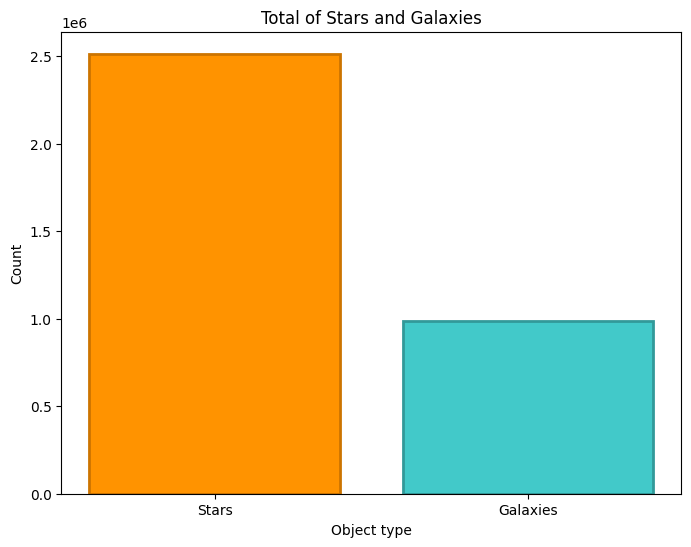

In [7]:
import matplotlib.pyplot as plt
import pandas as pd

number_stars = df.filter(df.type == 6).count()
number_galaxies = df.filter(df.type == 3).count()

#Convert the data into a dataframe to make the plot
data = pd.DataFrame({
    "type": ["Stars", "Galaxies"],
    "count": [number_stars, number_galaxies]
})


plt.figure(figsize=(8, 6))
plt.bar(data["type"], data["count"], color=["#ff9300", "#42c9c9"], edgecolor=["#cc7400", "#329999"], linewidth=2)
plt.xlabel("Object type")
plt.ylabel("Count")
plt.title("Total of Stars and Galaxies")


plt.show()

The amount of galaxies are less than the amount of stars, which make sense.

The next step is to change "type" label. As it is a binary classification, we will update stars to 0 and galaxies to 1.

In [8]:
df = df.withColumn("type", when(col("type") == 3,1).otherwise(0))

In [9]:
df_stars = df.filter(df["type"] == 0)
df_galaxies = df.filter(df["type"] == 1)

#Print to know the conversion is correctly done
df_stars.show(5)
df_galaxies.show(5)

+-------------------+---------+----------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+--------------+-----+
|              objID|       ra|       dec|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|     u_g|     g_r|      r_i|      i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i|fracDeV_z|         flags|clean|
+-------------------+---------+----------+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+--------+--------+---------+---------+---------+---------+---------+---------+---------+--------------+-----+
|1237648704596673596|228.13359|0.06267392|   0|  7.357505|  1.31

Now, we are going to select the columns that are convenient to use them in the model. We are not going to take into account:
- objID
- ra
- dec
- flags
- clean

This is because these features are not critical to distinguish between the classes, there are just informative columns about the characteristics of the object (identifier, position and correctness).

In [10]:
df_ml_model = df.select("type", "petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z",
                        "modelMag_u", "modelMag_g", "modelMag_r", "modelMag_i", "modelMag_z",
                        "psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z",
                        "u_g", "g_r", "r_i", "i_z",
                        "fracDeV_u", "fracDeV_g", "fracDeV_r", "fracDeV_i", "fracDeV_z")

df_ml_model.printSchema()

root
 |-- type: integer (nullable = false)
 |-- petroRad_u: float (nullable = true)
 |-- petroRad_g: float (nullable = true)
 |-- petroRad_r: float (nullable = true)
 |-- petroRad_i: float (nullable = true)
 |-- petroRad_z: float (nullable = true)
 |-- modelMag_u: float (nullable = true)
 |-- modelMag_g: float (nullable = true)
 |-- modelMag_r: float (nullable = true)
 |-- modelMag_i: float (nullable = true)
 |-- modelMag_z: float (nullable = true)
 |-- psfMag_u: float (nullable = true)
 |-- psfMag_g: float (nullable = true)
 |-- psfMag_r: float (nullable = true)
 |-- psfMag_i: float (nullable = true)
 |-- psfMag_z: float (nullable = true)
 |-- u_g: float (nullable = true)
 |-- g_r: float (nullable = true)
 |-- r_i: float (nullable = true)
 |-- i_z: float (nullable = true)
 |-- fracDeV_u: float (nullable = true)
 |-- fracDeV_g: float (nullable = true)
 |-- fracDeV_r: float (nullable = true)
 |-- fracDeV_i: float (nullable = true)
 |-- fracDeV_z: float (nullable = true)



To know more about these features we are going to plot correlations matrices but making an intelligent distribution of the columns, otherwise, we will obtain a huge heatmap hard to understand and analyse. For that, we are going to get each magnitudes and each wave separately.

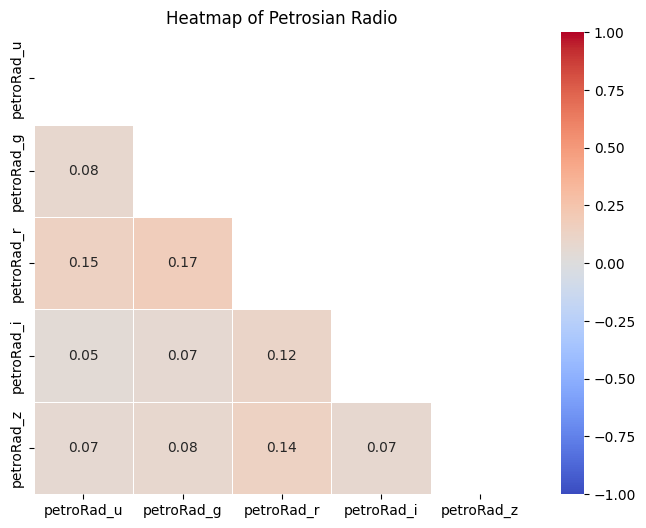

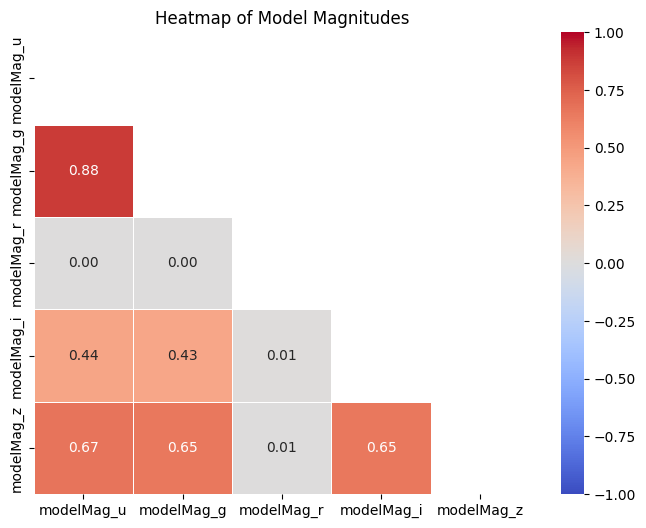

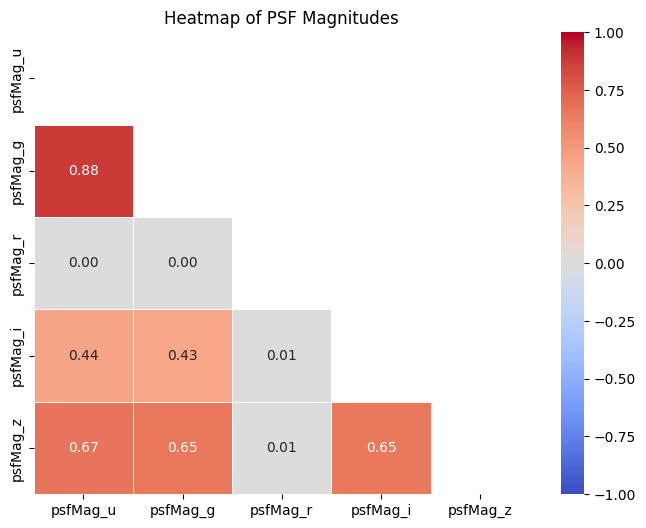

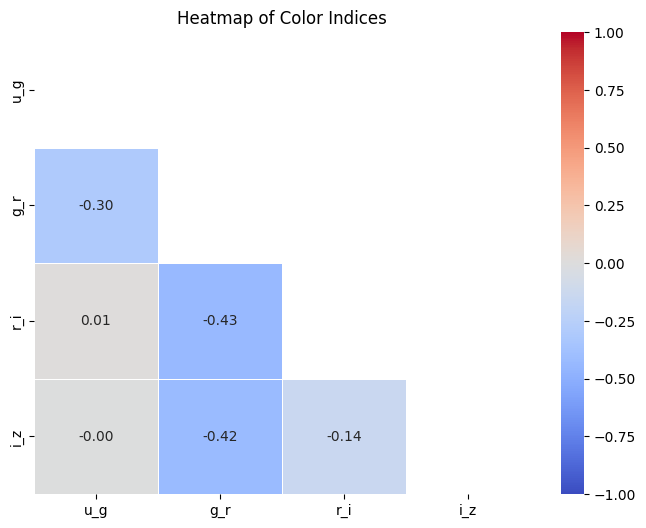

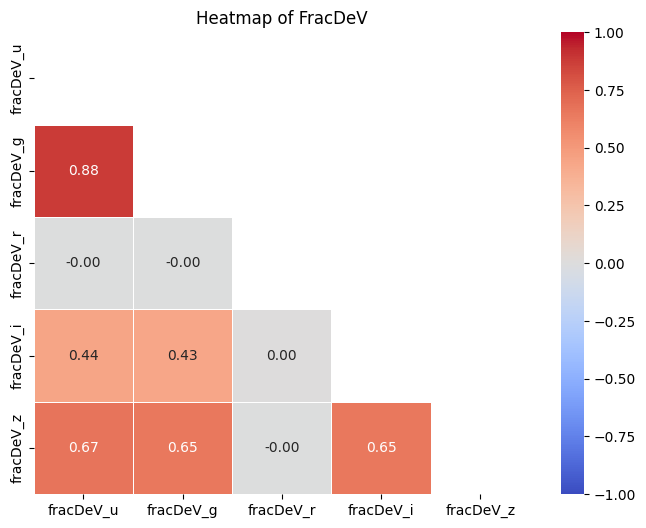

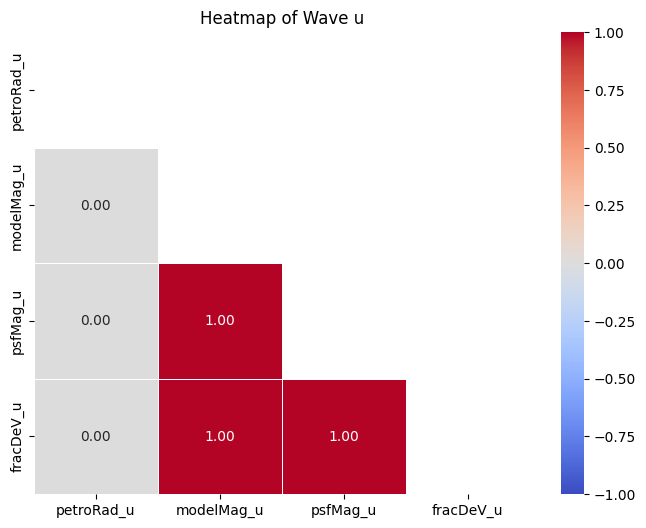

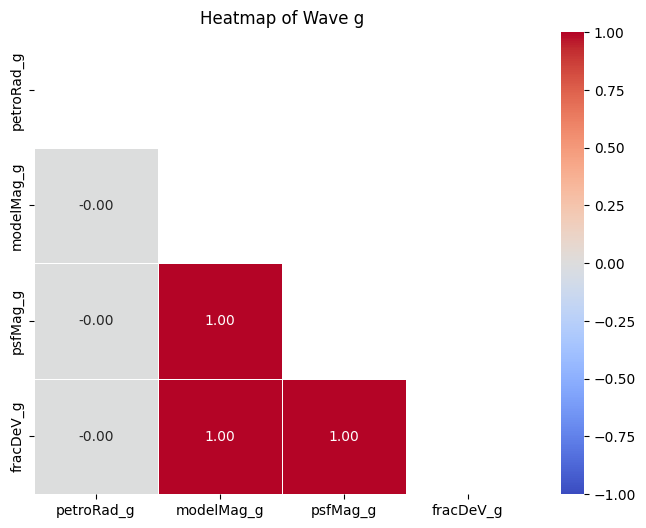

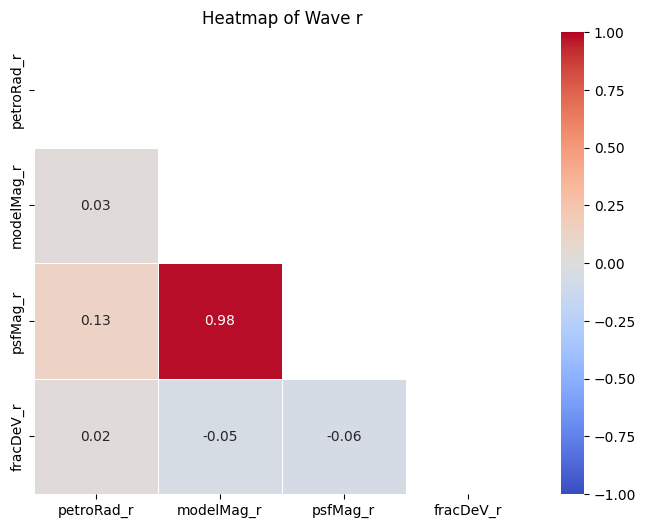

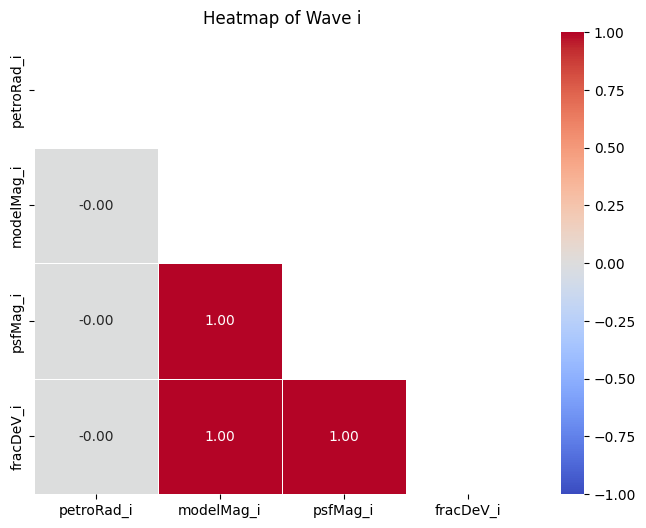

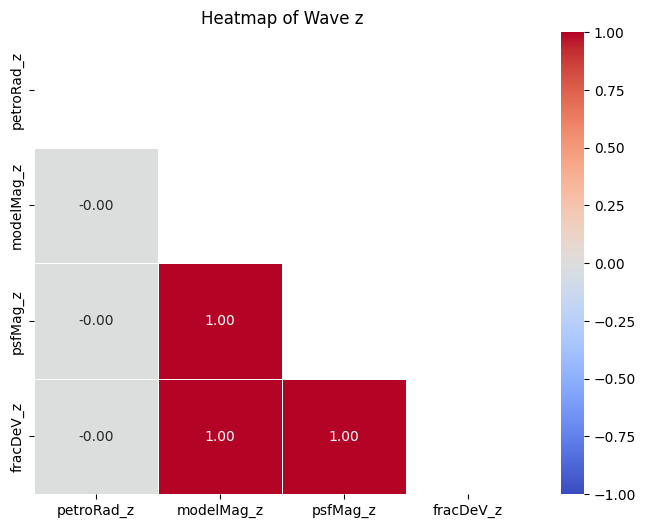

In [11]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

df_pd = df_ml_model.toPandas()

#Remove the column type, it is not numerical
df_corr = df_pd.drop(columns=["type"]).corr()

groups = {
    "Petrosian Radio": ["petroRad_u", "petroRad_g", "petroRad_r", "petroRad_i", "petroRad_z"],
    "Model Magnitudes": ["modelMag_u", "modelMag_g", "modelMag_r", "modelMag_i", "modelMag_z"],
    "PSF Magnitudes": ["psfMag_u", "psfMag_g", "psfMag_r", "psfMag_i", "psfMag_z"],
    "Color Indices": ["u_g", "g_r", "r_i", "i_z"],
    "FracDeV": ["fracDeV_u", "fracDeV_g", "fracDeV_r", "fracDeV_i", "fracDeV_z"],
    "Wave u": ["petroRad_u", "modelMag_u", "psfMag_u", "fracDeV_u"],
    "Wave g": ["petroRad_g", "modelMag_g", "psfMag_g", "fracDeV_g"],
    "Wave r": ["petroRad_r", "modelMag_r", "psfMag_r", "fracDeV_r"],
    "Wave i": ["petroRad_i", "modelMag_i", "psfMag_i", "fracDeV_i"],
    "Wave z": ["petroRad_z", "modelMag_z", "psfMag_z", "fracDeV_z"]

}

def plot_heatmap(df, cols, title):
    df_corr = df[cols].corr()  #Calculate the corralation matrix
    mask = np.triu(np.ones_like(df_corr, dtype=bool))  #Show the half of the matrix: it is symmetrical

    plt.figure(figsize=(8, 6))
    sns.heatmap(df_corr, mask=mask, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5, vmin=-1, vmax=1)
    plt.title(f"Heatmap of {title}")
    plt.show()

#Plot its heatmap
for group_name, columns in groups.items():
    plot_heatmap(df_pd, columns, group_name)

As we can see, if we separate each wave:
- Variables fracDev, modelMag and psfMag are strongly positively correlated. However, modelMag and psfMag are not so correlated for r wave. This is because they are probably measuring similar characteristics of the object, which is true because they measure the brightness of the object. **Galaxies** usually have high **fracDeV and modelMag** whereas **psfMag** is better to measure the **stars** brightness because they are point sources.
- psfMag and modelMag are also fully correlated with all the waves.

The difference behavior in the wave r it can be because of different reasons:
- Noise in the r-band: The r-band measurements might be affected by detector noise, calibration issues, or atmospheric effects.
- Characteristics of red light: This band is the visible light so it can happen that galaxies and stars emit similar amount of light in this band. 

To know which is the problem, we are going to use a boxplot to know if the band r is a good indicator.

/tmp/ipykernel_6071/2585691179.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data=df_pd, x="type", y="fracDeV_r", palette=colors)


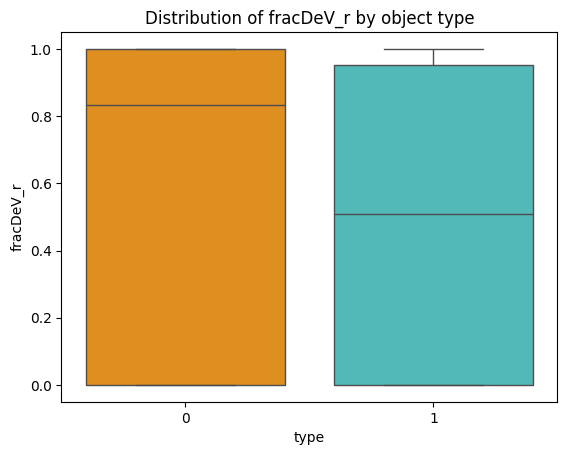

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

colors = ['#ff9300', '#42c9c9']

ax = sns.boxplot(data=df_pd, x="type", y="fracDeV_r", palette=colors)
plt.title("Distribution of fracDeV_r by object type")
plt.show()

As we can see, the mean of the values for type 0 (stars) is close to 1, suggesting that stars have a more compact, point-like shape. On the other hand, the values for type 1 (galaxies) are more dispersed, with a median around 0.5, indicating that galaxies are more extended and harder to distinguish using this feature.

On the other hand, the heatmaps of modelMag, psfMag, and fracDeV show very similar patterns. This means that these different features are highly correlated and may be redundant when used together in a model. However, we will first train a model using all features, and then apply PCA to compare the performance of both approaches.


## Spark ML

We will set a random seed to ensure reproducibility.

In [13]:
import set_seed


set_seed.set_seed(132)

As our objective is to create a machine learning model, we need to convert the data in a correct format: Vectors.

In [14]:
from pyspark.ml.feature import VectorAssembler

features = df_ml_model.columns[1:] #We don't get the type beacuse is the result we want to get.
assembler = VectorAssembler(inputCols = features, outputCol = "features") #Convert features list as a vector
df_ml_model = assembler.transform(df_ml_model) #Apply transformation
df_ml_model = df_ml_model.select("features", "type")

df_ml_model.head(5)

[Row(features=DenseVector([2.9693, 2.9694, 2.2205, 1.2498, 1.6223, 23.7184, 23.5512, 21.7066, 21.0708, 20.9492, 23.7153, 24.2585, 22.4114, 21.5338, 21.4554, 0.1672, 1.8446, 0.6358, 0.1216, 1.0, 0.0, 1.0, 1.0, 1.0]), type=1),
 Row(features=DenseVector([2.9693, 1.1675, 1.7132, 4.1938, 1.5817, 26.2304, 23.0677, 21.6006, 21.0439, 20.495, 25.8125, 23.3006, 22.1662, 21.5961, 20.9335, 3.1627, 1.467, 0.5567, 0.5489, 0.0, 1.0, 0.5398, 1.0, 0.0]), type=1),
 Row(features=DenseVector([7.3575, 1.3172, 1.0486, 0.9809, 0.9447, 23.2214, 21.6643, 20.2941, 19.1296, 18.5325, 23.2969, 21.694, 20.3222, 19.1463, 18.5552, 1.5571, 1.3702, 1.1645, 0.597, 1.0, 1.0, 1.0, 0.0, 0.0]), type=0),
 Row(features=DenseVector([4.5831, 1.8019, 1.7124, 1.6114, 1.6939, 24.1385, 22.0195, 21.3337, 21.0293, 21.2284, 24.3523, 22.5369, 21.9557, 21.7626, 21.684, 2.119, 0.6858, 0.3044, -0.1991, 0.2213, 0.0, 0.0, 0.0, 0.0]), type=1),
 Row(features=DenseVector([7.3575, 1.2759, 1.898, 2.2196, 2.8063, 25.9456, 22.6729, 20.7697, 20.014

Now, we are going to divide the dataset into train and test, so we can get the accuracy of the model.

In [15]:
train_data, test_data = df_ml_model.randomSplit([0.8, 0.2], seed = 132)

We are going to try different models to check which is the best for our case.

In [16]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC

#Define different models
models = {
    "Logistic Regression": LogisticRegression(labelCol="type", featuresCol="features"),
    "Decision Tree": DecisionTreeClassifier(labelCol="type", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="type", featuresCol="features", numTrees=5),
    "Gradient Boosted Trees": GBTClassifier(labelCol="type", featuresCol="features"),
    "Linear SVM": LinearSVC(labelCol="type", featuresCol="features")
}

Now, we are going to calculate the **AUC evaluator** for each model and look how well they are doing. I decided to use AUC because it is a good technique to use for binary classification, especially when classes are unbalanced.

Remember that the ROC curve gives a visual representation between the true prositive rate and false positive rate at different thresholds. So, it tell us how well the model can detect true positive and avoid false positives. Moreover, AUC is one scalar value from 0 to  that tell how the model performs globally. AUC represents the area beneath the curve.
- AUC = 0.5 ⭢ Random Predictions
- AUC > 0.5 ⭢ Increasingly good predictions
- AUC = 1 ⭢ Perfect predictions



![](notebookImages/img2.png)

In [17]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from sklearn.metrics import auc

evaluator = BinaryClassificationEvaluator(labelCol="type", metricName="areaUnderROC")

for name, model in models.items():
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data)
    auc = evaluator.evaluate(predictions)
    print(f"{name}: AUC = {auc:.4f}")

Logistic Regression: AUC = 0.9920


Decision Tree: AUC = 0.8420


Random Forest: AUC = 0.9744


Gradient Boosted Trees: AUC = 0.9869


Linear SVM: AUC = 0.9887


We are going to plot the results using matplot and sklearn.

The model Linear SVM does not have 'probability' column so it will not be in the graphic.


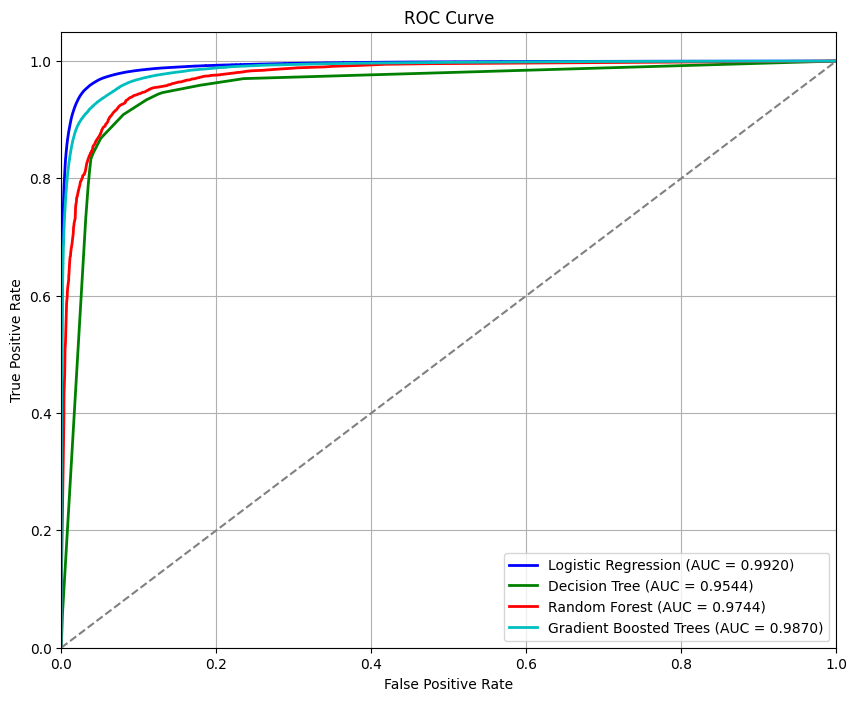

In [18]:
from sklearn.metrics import roc_curve, auc

#Create the figure
plt.figure(figsize=(10, 8))

#Different colors for the different models
colors = ['b', 'g', 'r', 'c', 'm']

#For each model compute the AUC
for idx, (name, model) in enumerate(models.items()):
    model_trained = model.fit(train_data)
    predictions = model_trained.transform(test_data) #Predicted class (0 or 1)

    #Check if the model has "probability" column because some of them (SVG for example) do not
    if "probability" in predictions.columns:
        #Get the whole probability vector, convert it into rdd and select the probability for the positive (real) prediction
        prob_positives = predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
        #Get the label for each prediction
        true_labels = predictions.select("type").rdd.map(lambda row: row[0]).collect()

        #Calculate ROC curve
        fpr, tpr, _ = roc_curve(true_labels, prob_positives)
        roc_auc = auc(fpr, tpr)

        #Plot it
        plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    else:
        print(f"The model {name} does not have 'probability' column so it will not be in the graphic.")

#Different parameters to personalize the plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #Diagonal line of "randomness"
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

plt.show()

The AUC for Decision Tree is different in the plot and in the obtained numerical values. That is because PySpark uses BinaryClassificationEvaluator, so it is evaluating with the class prediction (star or galaxy), whereas scikit-learn uses the predicted probabilities to calculate the AUC. That is why scikit-learn should be more precise.

Taking this into account, the best AUC is the one for logistic regression so we will use that model in order to make our predictions. 

Then, as our model has a very high AUC, we need to ensure that it is not overfitted. A high AUC does not necessarily mean good generalization; it could indicate that the model memorized the training data.

To ensure about this, we will compute the confusion matrix for training and test sets. Comparing both we will know if the model is performing well or not with unseen data. We will use plots to visualize the matrices in order to make an easier and more interpetable comparison.

In [19]:
lr = LogisticRegression(labelCol="type", featuresCol="features")
lr_model = lr.fit(train_data)

predictions_log_train = lr_model.transform(train_data)
predictions_log_test = lr_model.transform(test_data)

auc_train = evaluator.evaluate(predictions_log_train)
auc_test = evaluator.evaluate(predictions_log_test)

print(f"Logistic Regression (Train): AUC = {auc_train:.4f}\n")
print(f"Logistic Regression (Test): AUC = {auc_test:.4f}")

Logistic Regression (Train): AUC = 0.9918

Logistic Regression (Test): AUC = 0.9919


As we can see, the difference is almost non-existent which is good because this suggests that the model is generalizing correctly, data for train and test set are representative of the data. However, as it is a very high AUC, we can verify the confusion matrix in order to know if the model is correctly classifying. To make this, we will use the plot of the confusion matrix to visualize to get a conclusion in a easier and more interpetable way.

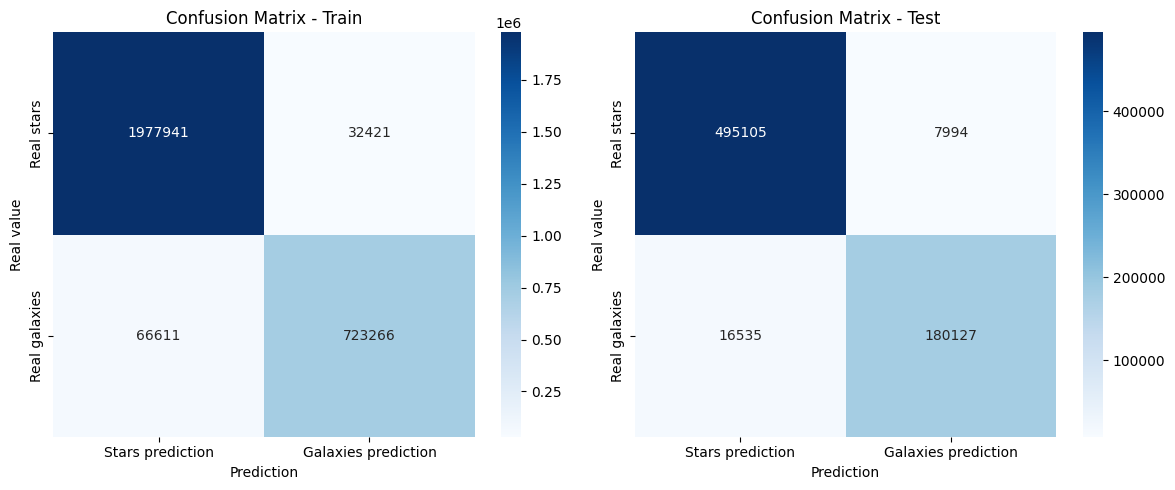

In [ ]:
from pyspark.sql import functions as F
import seaborn as sns
import numpy as np

#Divide true positives, true negatives, false positives and false negatives
##Train
true_galaxies_train = predictions_log_train.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_train = predictions_log_train.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_train = predictions_log_train.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_train = predictions_log_train.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_train = [[true_stars_train, false_stars_train], [false_galaxies_train, true_galaxies_train]]


##Test
true_galaxies_test = predictions_log_test.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_test = predictions_log_test.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_test = predictions_log_test.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_test = predictions_log_test.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_test = [[true_stars_test, false_stars_test], [false_galaxies_test, true_galaxies_test]]


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

#Train confusion matrix
ax1 = sns.heatmap(np.array(conf_matrix_values_train), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[0]) #Put in the axe 0, the left one
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Real value")
ax1.set_title("Confusion Matrix - Train")

#Test confusion matrix
ax2 = sns.heatmap(np.array(conf_matrix_values_test), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[1]) #Put in the axe 0, the right one
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Real value")
ax2.set_title("Confusion Matrix - Test")


plt.tight_layout()
plt.show()


To detect if there is or not overfitting, we need to compare the error rate in train and test set. 

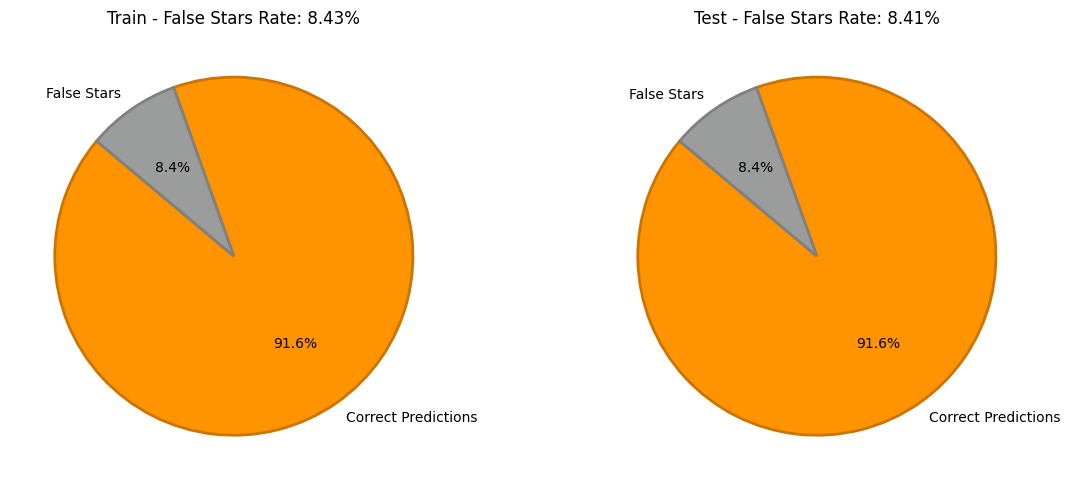

In [21]:
##Train
false_stars_train = conf_matrix_values_train[1][0]
true_galaxies_train = conf_matrix_values_train[1][1]

false_stars_train_rate = ((false_stars_train)/(false_stars_train + true_galaxies_train))*100
false_stars_train_rate = round(false_stars_train_rate,2)


##Test
false_stars_test = conf_matrix_values_test[1][0]
true_galaxies_test = conf_matrix_values_test[1][1]

false_stars_test_rate = ((false_stars_test)/(false_stars_test + true_galaxies_test))*100
false_stars_test_rate = round(false_stars_test_rate,2)


#PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line
colors_train = ["#ff9300", "#9b9c9c"]
edge_colors = ["#cc7400", "#808080"]  #Darker border colors

#Train Pie Chart
sizes_train = [100 - false_stars_train_rate, false_stars_train_rate]
wedges_train, _, autotexts_train = axes[0].pie(
    sizes_train, labels=["Correct Predictions", "False Stars"], autopct='%1.1f%%', colors=colors_train, startangle=140,
    wedgeprops={"linewidth": 2}  # General border thickness
)

#Set custom edge colors for Train pie chart
for wedge, edge_color in zip(wedges_train, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[0].set_title(f"Train - False Stars Rate: {false_stars_train_rate}%")

#Test Pie Chart
sizes_test = [100 - false_stars_test_rate, false_stars_test_rate]
wedges_test, _, autotexts_test = axes[1].pie(
    sizes_test, labels=["Correct Predictions", "False Stars"], autopct='%1.1f%%', colors=colors_train, startangle=140,
    wedgeprops={"linewidth": 2}  # General border thickness
)

#Set custom edge colors for Test pie chart
for wedge, edge_color in zip(wedges_test, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[1].set_title(f"Test - False Stars Rate: {false_stars_test_rate}%")

plt.tight_layout()
plt.show()

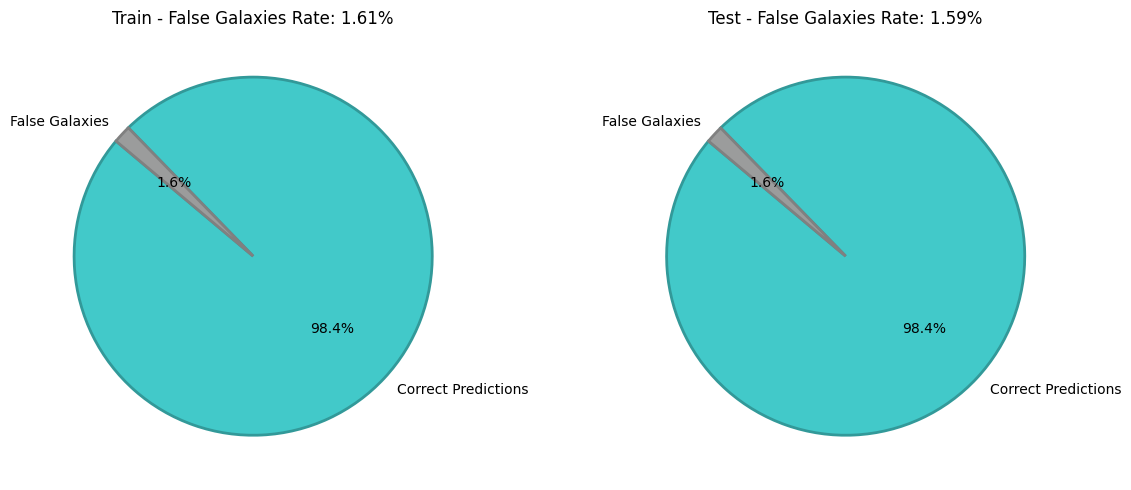

In [22]:
import matplotlib.pyplot as plt

##Train
false_galaxies_train = conf_matrix_values_train[0][1]
true_stars_train = conf_matrix_values_train[0][0]

false_galaxies_train_rate = ((false_galaxies_train) / (false_galaxies_train + true_stars_train)) * 100
false_galaxies_train_rate = round(false_galaxies_train_rate, 2)

##Test
false_galaxies_test = conf_matrix_values_test[0][1]
true_stars_test = conf_matrix_values_test[0][0]

false_galaxies_test_rate = ((false_galaxies_test) / (false_galaxies_test + true_stars_test)) * 100
false_galaxies_test_rate = round(false_galaxies_test_rate, 2)


##PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ["#42c9c9", "#9b9c9c"] 
edge_colors = ["#329999", "#808080"]

#Train 
sizes_train = [100 - false_galaxies_train_rate, false_galaxies_train_rate]
wedges_train, _, autotexts_train = axes[0].pie(
    sizes_train, labels=["Correct Predictions", "False Galaxies"], autopct='%1.1f%%', colors=colors, startangle=140,
    wedgeprops={"linewidth": 2} 
)

#Set custom edge colors for Train pie chart
for wedge, edge_color in zip(wedges_train, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[0].set_title(f"Train - False Galaxies Rate: {false_galaxies_train_rate}%")

#Test 
sizes_test = [100 - false_galaxies_test_rate, false_galaxies_test_rate]
wedges_test, _, autotexts_test = axes[1].pie(
    sizes_test, labels=["Correct Predictions", "False Galaxies"], autopct='%1.1f%%', colors=colors, startangle=140,
    wedgeprops={"linewidth": 2} 
)

#Test
for wedge, edge_color in zip(wedges_test, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[1].set_title(f"Test - False Galaxies Rate: {false_galaxies_test_rate}%")

plt.tight_layout()
plt.show()

As both rates (train and test) are very similar, the model is not overfitting so it is generalizing correctly the data. However, As the AUC value is very big, we can use **regularization** technique to make a more robust model. Regularization is intended to prevent overfitting by penalizing large coefficients and forcing the model to learn simpler and more generalizable patterns. There are different types of regularization (L1, L2 (same that L1 but squared), L1+L2, dropout,...). In this case, we will use L2 regularization because it is the most estable one and because all the selected variables are relevant. For that, it is necessary to add *regParam* to the Logistic Regression. The selected value 0.1 is because it is a simple model, it has not many variables (just 24).

In [23]:
lr_with_reg = LogisticRegression(labelCol="type", featuresCol="features", regParam=0.1)
model_with_reg = lr_with_reg.fit(train_data)

#Evaluate the model with regularization
predictions_with_reg = model_with_reg.transform(test_data)
auc_with_reg = evaluator.evaluate(predictions_with_reg)
print(f"Logistic Regression (Regularization): AUC = {auc_with_reg:.4f}")

Logistic Regression (Regularization): AUC = 0.9066


As we can see, the AUC has decreased from 0.9919 to 0.9066 (in test). This will be good for the model to learn more generalizable patterns and not to overfit.

## PCA

PCA is a technique that is used to reduce the dimensionality to simplify a large data set into a smaller one while maintaining significant patterns and trends. Trying to simplify the data we have, we are going to apply this technique. In this case, we will eliminate objID, ra, dec, flags and clean columns because we will not use it to train the models. Moreover, these features do not give us any information to classify the inspected object into a star or galaxy.

In [24]:
df_filtered = df.drop(*["objID", "flags", "clean", "ra", "dec"])
df_filtered.show()

+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+---------+------------+----------+---------+---------+---------+---------+----------+
|type|petroRad_u|petroRad_g|petroRad_r|petroRad_i|petroRad_z|modelMag_u|modelMag_g|modelMag_r|modelMag_i|modelMag_z|psfMag_u|psfMag_g|psfMag_r|psfMag_i|psfMag_z|      u_g|      g_r|         r_i|       i_z|fracDeV_u|fracDeV_g|fracDeV_r|fracDeV_i| fracDeV_z|
+----+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+--------+--------+--------+--------+--------+---------+---------+------------+----------+---------+---------+---------+---------+----------+
|   1|  2.969285|  2.969369|  2.220518|  1.249783|   1.62232|  23.71841|  23.55119|  21.70663|  21.07082|  20.94918|23.71531|24.25853|22.41145|21.53375|21.45539|0.1672249| 1.844557|   0.6358051| 0.1216412|      1.0|      0.0|    

We are going to check the number of rows and columns in the dataset. Additionally, we will split the data into training and test sets, separating the label in each case because it is an unsupervised learning method.

In [25]:
import numpy as np

df_filtered = df_filtered.toPandas()

In [26]:
X = df_filtered.drop(columns = ["type"])
Y = df_filtered["type"]

n_rows, n_cols = X.shape

print(f"Number of rows: {n_rows}")
print(f"Number of columns: {n_cols}")

Number of rows: 3500000
Number of columns: 24


In [27]:
from sklearn.model_selection import train_test_split

#Split the data: train (80%) and test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=132)

print("Size of X_train:", X_train.shape)
print("Size of X_test:", X_test.shape)

Size of X_train: (2800000, 24)
Size of X_test: (700000, 24)


Now, we are going to normalize/standardize the data so all variables are in the same scale.

In [28]:
from sklearn.preprocessing import StandardScaler

#Standardize the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train) #We fit just with the train data
X_test_scaled = scaler.transform(X_test)

We are going to calculate the accumulated explained variance and the variance of each component of PCA to select the k optimal value and reduce the dimensions of the data to apply in the model.

In [29]:
import pandas as pd
from sklearn.decomposition import PCA

pca = PCA(n_components=n_cols)  #Taking into account that the number of components will be the matrix rank
pca.fit(X_train_scaled)

exp_variance = pd.DataFrame(data=pca.explained_variance_ratio_,
                            index=['PC' + str(n_pca + 1) for n_pca in range(pca.n_components)],
                            columns=['Exp_variance'])

exp_variance['cum_Exp_variance'] = exp_variance['Exp_variance'].cumsum()
exp_variance.head(24)

,Exp_variance,cum_Exp_variance
PC1,4.220592e-01,0.422059
PC2,1.245541e-01,0.546613
PC3,8.630823e-02,0.632922
PC4,6.443581e-02,0.697357
PC5,5.572633e-02,0.753084
PC6,5.538291e-02,0.808467
PC7,4.131655e-02,0.849783
PC8,3.995438e-02,0.889737
PC9,3.840242e-02,0.928140
PC10,3.799396e-02,0.966134


We can change the threshold if we want to have more or less variance in the model. Taking this value into account, the plot will tell us the optimal value to reach that variance.

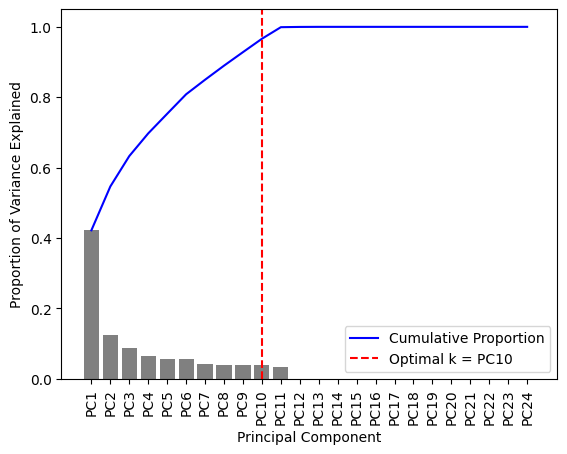

Optimal k (number of components) based on 95.0% variance: PC10


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

#Threshold to know the acumulated variances
threshold = 0.95

#Get the first index for k where we get the selected theshold
optimal_k = exp_variance[exp_variance['cum_Exp_variance'] >= threshold].index[0]

#PLOT
sns.barplot(data=exp_variance, x=exp_variance.index, y='Exp_variance', color='gray')
sns.lineplot(data=exp_variance, x=exp_variance.index, y='cum_Exp_variance', color='blue', label='Cumulative Proportion')
plt.axvline(x=optimal_k, color='red', linestyle='--', label=f'Optimal k = {optimal_k}')

plt.ylabel('Proportion of Variance Explained')
plt.xlabel('Principal Component')
plt.xticks(rotation=90)
plt.legend()
plt.show()

print(f"Optimal k (number of components) based on {threshold*100}% variance: {optimal_k}")


We will also try using the log-likelihood to find the best k value. To do this, we will define a function to calculate the log-likelihood based on the explained variances obtained from the PCA.

In [ ]:
from scipy.stats import multivariate_normal

def log_likelihood(evals):

    Lmax = len(evals)
    ll = np.arange(0.0, Lmax)

    for L in range(Lmax):
        group1 = evals[0 : L + 1]  #Divide Eigenvalues in two groups
        group2 = evals[L + 1 : Lmax]

        mu1 = np.mean(group1)
        mu2 = np.mean(group2)

        #eqn (20.30)
        sigma = (np.sum((group1 - mu1) ** 2) + np.sum((group2 - mu2) ** 2)) / Lmax

        ll_group1 = np.sum(multivariate_normal.logpdf(group1, mu1, sigma))
        ll_group2 = np.sum(multivariate_normal.logpdf(group2, mu2, sigma))

        ll[L] = ll_group1 + ll_group2  
    return ll

Now, we are going to plot it.

/home/haizeagonzalez/myproject/bigdataenv/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:3860: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/haizeagonzalez/myproject/bigdataenv/lib/python3.12/site-packages/numpy/_core/_methods.py:145: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


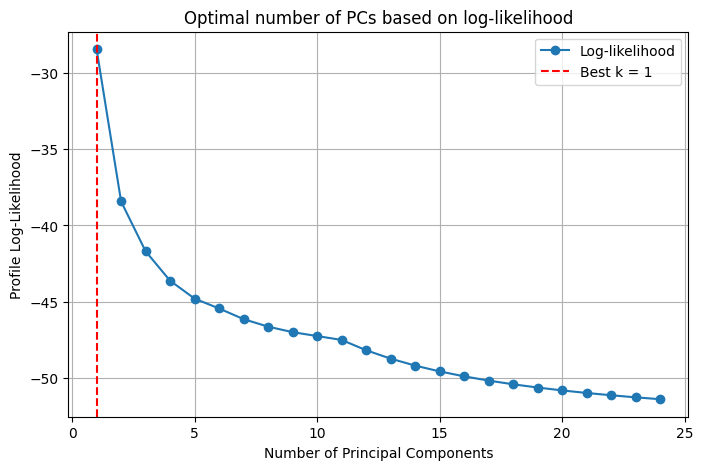

Optimal k (based on log-likelihood): 1


In [32]:
evals = pca.explained_variance_

ll = log_likelihood(evals)

max_k = min(50, len(evals)) #We are taking as much 50 components. If there are less, we get that number
xs = np.arange(1, max_k + 1) #Array that contains the labels for x axis: [0, 1, 2,...]
ys = ll[:max_k] #Gets the log-likelihood for the max_k evaluated components

plt.figure(figsize=(8, 5))
plt.plot(xs, ys, marker='o', label='Log-likelihood') #Curve
idx = np.argmax(ys) #Maximum value in ys (biggest log-likelihood)
plt.axvline(xs[idx], color='red', linestyle='--', label=f'Best k = {xs[idx]}') #Vertical line for the best k
plt.xlabel("Number of Principal Components")
plt.ylabel("Profile Log-Likelihood")
plt.title("Optimal number of PCs based on log-likelihood")
plt.legend()
plt.grid(True)
plt.show()

print(f"Optimal k (based on log-likelihood): {int(xs[idx])}")

In [ ]:
print(f"Optimal k (Log-likelihood): {xs[idx]}")
print(f"Optimal k (number of components) based on {threshold*100}% variance: {optimal_k}")


Optimal k (Log-likelihood): 1
Optimal k (number of components) based on 95.0% variance: PC10


As we see, the optimal k is different for each technique. This is because the first component (PC1) explains much more variance comparing to the rest, and the log-likelihood model assumes that the other values are noise. However, as the first component just explains the 42% of the variance, we will keep the k=10.

### Analyse

Before applying this into a model, we will analyse some chacteristics of the PCA. First, we are going to check which are the more important features for each component. For that, we are going to calculate the different loadings for each component and select the top 5 features (in absolute value).

In [34]:
from sklearn.decomposition import PCA
import pandas as pd

k_number = int(optimal_k.replace('PC', '')) 

pca = PCA(n_components=k_number)
pca.fit(X)  #Adjust PCA to our data

#Get the loads of the principal components
component_loadings = pd.DataFrame(pca.components_.T, 
                                  columns=[f'PC{i+1}' for i in range(pca.n_components_)], 
                                  index=X.columns)

In [35]:
import pandas as pd

top_features = {}

n_components = component_loadings.shape[1]

#Get the top 5 characteristics for each component, those more important (give more information to de component)
for i in range(n_components):
    top_features[f'PC{i+1}'] = component_loadings.abs().nlargest(5, f'PC{i+1}').index

top_features_df = pd.DataFrame(top_features)
top_features_df.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10
0,psfMag_g,modelMag_i,u_g,i_z,petroRad_u,psfMag_i,petroRad_g,petroRad_i,petroRad_z,psfMag_r
1,modelMag_g,r_i,i_z,u_g,petroRad_g,r_i,petroRad_i,petroRad_g,petroRad_i,modelMag_r
2,g_r,fracDeV_i,psfMag_u,psfMag_z,petroRad_r,fracDeV_i,petroRad_r,petroRad_z,petroRad_g,petroRad_z
3,fracDeV_g,psfMag_i,modelMag_u,modelMag_z,petroRad_z,modelMag_i,petroRad_z,petroRad_r,petroRad_r,fracDeV_u
4,psfMag_u,psfMag_z,fracDeV_u,fracDeV_z,petroRad_i,i_z,petroRad_u,psfMag_r,psfMag_r,fracDeV_g


Now, we are going to plot the top 5 characteristics for PC1 and PC2 to know the weight of each one.

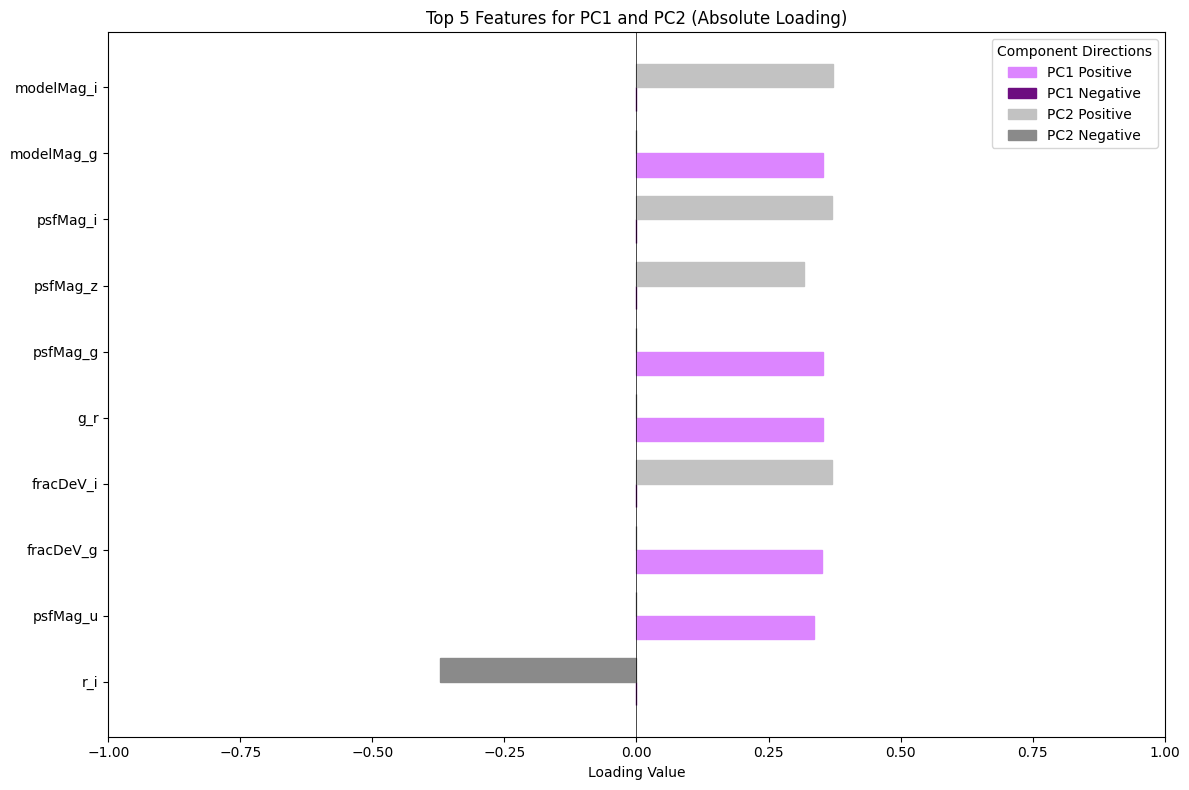

In [36]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

#Get top 5 features for each component (absolute values)
top_pc1 = component_loadings['PC1'].abs().nlargest(5).index
top_pc2 = component_loadings['PC2'].abs().nlargest(5).index

#Create the DataFrame
plot_data = []
for feature in set(top_pc1).union(set(top_pc2)):
    row = {'Feature': feature}
    if feature in top_pc1:
        row.update({'PC1_Value': component_loadings.loc[feature, 'PC1']})
    if feature in top_pc2:
        row.update({'PC2_Value': component_loadings.loc[feature, 'PC2']})
    plot_data.append(row)

plot_df = pd.DataFrame(plot_data).set_index('Feature')

COLOR_SCHEME = {
    'PC1+': '#dc85ff',
    'PC1-': '#6d0d80', 
    'PC2+': '#c2c2c2',
    'PC2-': '#8a8a8a'
}

#Change NaNs to 0
features = plot_df.index
pc1_values = plot_df['PC1_Value'].fillna(0)
pc2_values = plot_df['PC2_Value'].fillna(0)

fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.35
y_pos = np.arange(len(features))

#Bars for PC1
pc1_bars = ax.barh(y=y_pos - bar_width/2, width=pc1_values, 
                   height=bar_width, label='PC1')
#Bars for PC2
pc2_bars = ax.barh(y=y_pos + bar_width/2, width=pc2_values, 
                   height=bar_width, label='PC2')

#Assign colors
for bar, value in zip(pc1_bars, pc1_values):
    color = COLOR_SCHEME['PC1+'] if value > 0 else COLOR_SCHEME['PC1-']
    bar.set_color(color)

for bar, value in zip(pc2_bars, pc2_values):
    color = COLOR_SCHEME['PC2+'] if value > 0 else COLOR_SCHEME['PC2-']
    bar.set_color(color)


ax.set_yticks(y_pos)
ax.set_yticklabels(features)
ax.set_xlim(-1, 1)
ax.set_title('Top 5 Features for PC1 and PC2 (Absolute Loading)')
ax.set_xlabel('Loading Value')
ax.axvline(0, color='black', linewidth=0.5)

#Legend
legend_elements = [
    plt.Rectangle((0,0), 1, 1, color=COLOR_SCHEME['PC1+'], label='PC1 Positive'),
    plt.Rectangle((0,0), 1, 1, color=COLOR_SCHEME['PC1-'], label='PC1 Negative'),
    plt.Rectangle((0,0), 1, 1, color=COLOR_SCHEME['PC2+'], label='PC2 Positive'),
    plt.Rectangle((0,0), 1, 1, color=COLOR_SCHEME['PC2-'], label='PC2 Negative')
]
ax.legend(handles=legend_elements, loc='upper right', 
          title='Component Directions')

plt.tight_layout()
plt.show()

With this plot we can see which are the top 5 features for each component. For example: modelMag_i is approximately +0.4 for PC2, which means that this feature contributes positively to that component; contributes negatively those with negative values. With this plot we can understand which characteristics are most strongly correlated with the first two components (PC1 and PC2). These are the features that influence the data the most in the context of PCA. Features with high positive or negative values in PC1 and PC2 will have a significant impact on the way the data is represented in the new, reduced-dimensional space. 

### Spark ML

Once we obtain the optimal value of k, we will create a Spark DataFrame to use it in Spark ML. We need to remove the type column, as we will be applying PCA, which is an unsupervised learning method.

In [37]:
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#We have to create a DataFrame from Spark to use it in the models
df_spark = spark.createDataFrame(df_filtered)

features_pca = df_spark.columns[1:]#We don't get the type beacuse is the result we want to get.

assembler_pca = VectorAssembler(inputCols = features_pca, outputCol = "features") #Convert features list as a vector
df_ml_model_pca = assembler_pca.transform(df_spark) #Apply transformation
df_ml_model_pca = df_ml_model_pca.select("features", "type")

df_ml_model_pca.head(5)

[Row(features=DenseVector([2.9693, 2.9694, 2.2205, 1.2498, 1.6223, 23.7184, 23.5512, 21.7066, 21.0708, 20.9492, 23.7153, 24.2585, 22.4114, 21.5338, 21.4554, 0.1672, 1.8446, 0.6358, 0.1216, 1.0, 0.0, 1.0, 1.0, 1.0]), type=1),
 Row(features=DenseVector([2.9693, 1.1675, 1.7132, 4.1938, 1.5817, 26.2304, 23.0677, 21.6006, 21.0439, 20.495, 25.8125, 23.3006, 22.1662, 21.5961, 20.9335, 3.1627, 1.467, 0.5567, 0.5489, 0.0, 1.0, 0.5398, 1.0, 0.0]), type=1),
 Row(features=DenseVector([7.3575, 1.3172, 1.0486, 0.9809, 0.9447, 23.2214, 21.6643, 20.2941, 19.1296, 18.5325, 23.2969, 21.694, 20.3222, 19.1463, 18.5552, 1.5571, 1.3702, 1.1645, 0.597, 1.0, 1.0, 1.0, 0.0, 0.0]), type=0),
 Row(features=DenseVector([4.5831, 1.8019, 1.7124, 1.6114, 1.6939, 24.1385, 22.0195, 21.3337, 21.0293, 21.2284, 24.3523, 22.5369, 21.9557, 21.7626, 21.684, 2.119, 0.6858, 0.3044, -0.1991, 0.2213, 0.0, 0.0, 0.0, 0.0]), type=1),
 Row(features=DenseVector([7.3575, 1.2759, 1.898, 2.2196, 2.8063, 25.9456, 22.6729, 20.7697, 20.014

Now, we are going to follow the exactly same steps than before (without PCA) but when training the models, we are going to use a pipeline to determine that before training it, we are going to apply PCA.

In [38]:
train_data_pca, test_data_pca = df_ml_model_pca.randomSplit([0.8, 0.2], seed = 132)

In [39]:
#Define different models
models = {
    "Logistic Regression": LogisticRegression(labelCol="type", featuresCol="features"),
    "Decision Tree": DecisionTreeClassifier(labelCol="type", featuresCol="features"),
    "Random Forest": RandomForestClassifier(labelCol="type", featuresCol="features", numTrees=5),
    "Gradient Boosted Trees": GBTClassifier(labelCol="type", featuresCol="features"),
    "Linear SVM": LinearSVC(labelCol="type", featuresCol="features")
}

In [40]:
#Define PCA with the optimized k value
pca = PCA(k=k_number, inputCol="features", outputCol="pca_features")

#Select the evaluator
evaluator = BinaryClassificationEvaluator(labelCol="type", metricName="areaUnderROC")

#Apply PCA and train the models
for name, model in models.items():
    #Create the pipeline so first it will apply PCA and the the model
    pipeline = Pipeline(stages=[pca, model])
    
    #Fit the model with the train data
    model_trained = pipeline.fit(train_data_pca)
    
    #Make predictions with the test data
    predictions = model_trained.transform(test_data_pca)
    
    #Evaluate the model the same way than before
    auc = evaluator.evaluate(predictions)
    print(f"{name}: AUC = {auc:.4f}")


Logistic Regression: AUC = 0.9918


Decision Tree: AUC = 0.8349


Random Forest: AUC = 0.9735


Gradient Boosted Trees: AUC = 0.9867


Linear SVM: AUC = 0.9910


The model Linear SVM does not have 'probability' column so it will not be in the graphic.


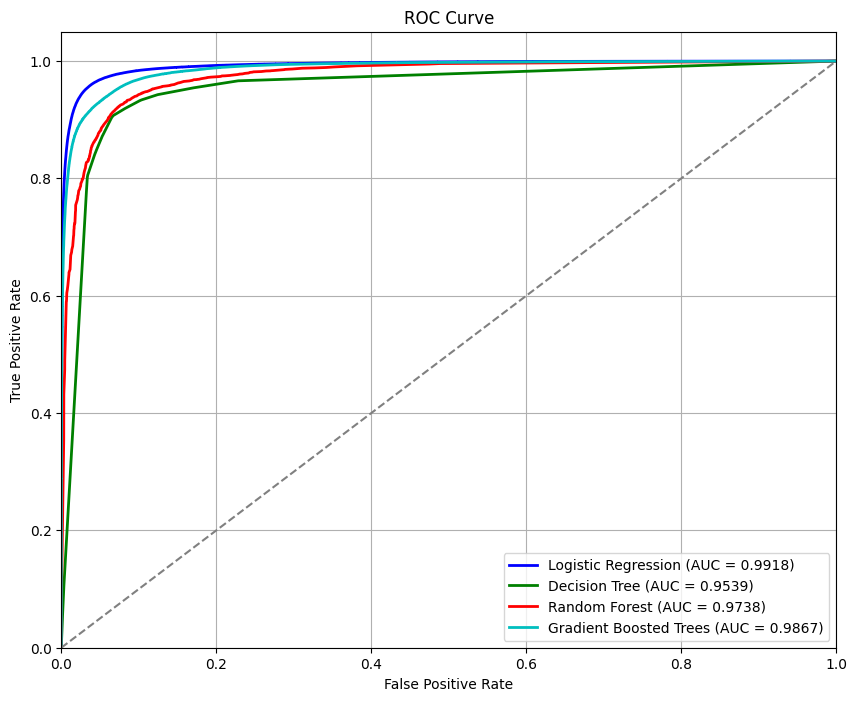

In [ ]:
from sklearn.metrics import roc_curve, auc

#Create the figure
plt.figure(figsize=(10, 8))

#Different colors for the different models
colors = ['b', 'g', 'r', 'c', 'm']

#For each model compute the AUC
for idx, (name, model) in enumerate(models.items()):
    model_trained = model.fit(train_data_pca)
    predictions = model_trained.transform(test_data_pca) #Predicted class (0 or 1)

    #Check if the model has "probability" column because some of them (SVG for example) do not
    if "probability" in predictions.columns:
        #Get the whole probability vector, convert it into rdd and select the probability for the positive (real) prediction
        prob_positives = predictions.select("probability").rdd.map(lambda row: row[0][1]).collect()
        #Get the label for each prediction
        true_labels = predictions.select("type").rdd.map(lambda row: row[0]).collect()

        #Calculate ROC curve
        fpr, tpr, _ = roc_curve(true_labels, prob_positives)
        roc_auc = auc(fpr, tpr)

        #PLOT
        plt.plot(fpr, tpr, color=colors[idx % len(colors)], lw=2, label=f'{name} (AUC = {roc_auc:.4f})')
    else:
        print(f"The model {name} does not have 'probability' column so it will not be in the graphic.")

#Different parameters to personalize the plot
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  #Diagonal line of "random"
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()

plt.show()

As we did for the previous model, we will use the regularization technique to avoid overfitting.

In [ ]:
lr_with_reg_pca = LogisticRegression(labelCol="type", featuresCol="features", regParam=0.1)
model_with_reg_pca = lr_with_reg_pca.fit(train_data_pca)

#Evaluate the model with regularization
predictions_with_reg_pca = model_with_reg_pca.transform(test_data_pca)
auc_with_reg_pca = evaluator.evaluate(predictions_with_reg_pca)
print(f"Logistic Regression (Regularization + PCA): AUC = {auc_with_reg_pca:.4f}")

### Obtained results 
Results obtained with **k = 10 → 95%** variance explained

**Logistic Regression**
- Without PCA: AUC = 0.9920
- PCA: AUC = 0.9918

**Decision Tree**
- Without PCA: AUC = 0.9544 
- PCA: AUC = 0.9539

**Random Forest**
- Without PCA: AUC = 0.9744
- PCA: AUC = 0.9738

**Gradient Boosted Trees**
- Without PCA: AUC = 0.9870 
- PCA: AUC = 0.9867

**Linear SVM**
- Without PCA: AUC = 0.9887 
- PCA: AUC = 0.9910

As we can see, all the results are very similar. However with PCA we obtained a better AUC value in Linear SVM.

The reason of this can be because this method is sensible to the amount and quality of features and when applying PCA, we are removing noisy or rdeundant characteristics so we are improving the performance of the model.



As before, the best model we get is the logistic regression. We are going to follow the same procedure to ensure that the model is not overfitted.

In [42]:
lr = LogisticRegression(labelCol="type", featuresCol="features")
lr_model = lr.fit(train_data_pca)

predictions_log_train_pca = lr_model.transform(train_data_pca)
predictions_log_test_pca = lr_model.transform(test_data_pca)

auc_train_pca = evaluator.evaluate(predictions_log_train_pca)
auc_test_pca = evaluator.evaluate(predictions_log_test_pca)

print(f"Logistic Regression (Train): AUC = {auc_train_pca:.4f}\n")
print(f"Logistic Regression (Test): AUC = {auc_test_pca:.4f}")

Logistic Regression (Train): AUC = 0.9918

Logistic Regression (Test): AUC = 0.9918


As before, it is a very high AUC so we have to check that the model is not overfitted. For that we will look the confusion matrix and the error percentage for training and test.

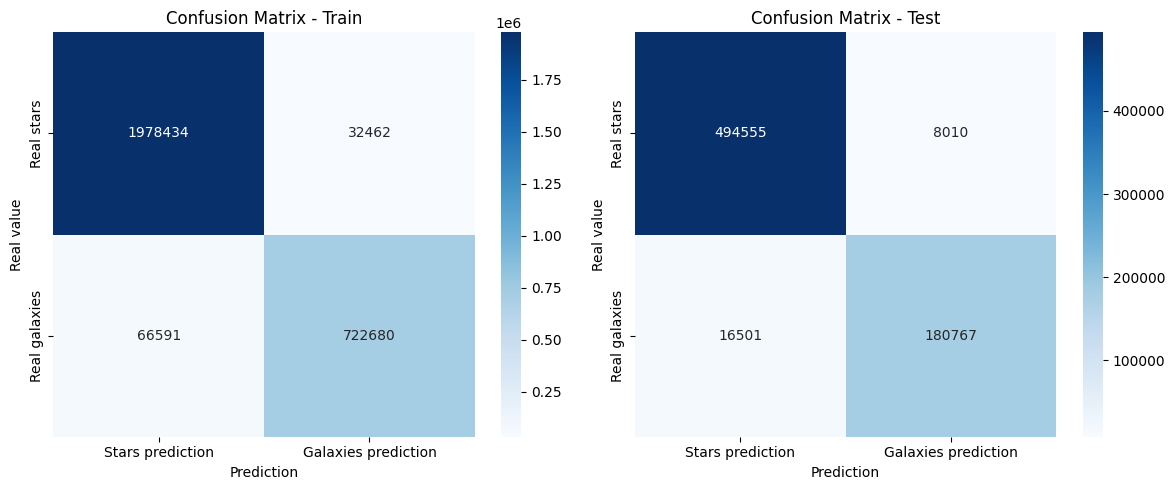

In [43]:
from pyspark.sql import functions as F
import seaborn as sns
import numpy as np

#Divide true positives, true negatives, false positives and false negatives
##Train
true_galaxies_train_pca = predictions_log_train_pca.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_train_pca = predictions_log_train_pca.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_train_pca = predictions_log_train_pca.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_train_pca = predictions_log_train_pca.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_train_pca = [[true_stars_train_pca, false_stars_train_pca], [false_galaxies_train_pca, true_galaxies_train_pca]]


##Test
true_galaxies_test_pca = predictions_log_test_pca.filter((F.col("type") == 1) & (F.col("prediction") == 1)).count()
true_stars_test_pca = predictions_log_test_pca.filter((F.col("type") == 0) & (F.col("prediction") == 0)).count()
false_stars_test_pca = predictions_log_test_pca.filter((F.col("type") == 0) & (F.col("prediction") == 1)).count()
false_galaxies_test_pca = predictions_log_test_pca.filter((F.col("type") == 1) & (F.col("prediction") == 0)).count()

#Creating the confusion matrix
conf_matrix_values_test_pca = [[true_stars_test_pca, false_stars_test_pca], [false_galaxies_test_pca, true_galaxies_test_pca]]


##PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  #Create two plots in 1 line

#Train confusion matrix
ax1 = sns.heatmap(np.array(conf_matrix_values_train_pca), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[0]) #Put in the axe 0, the left one
ax1.set_xlabel("Prediction")
ax1.set_ylabel("Real value")
ax1.set_title("Confusion Matrix - Train")

#Test confusion matrix
ax2 = sns.heatmap(np.array(conf_matrix_values_test_pca), annot=True, fmt="d", cmap="Blues",
                   xticklabels=["Stars prediction", "Galaxies prediction"],
                   yticklabels=["Real stars", "Real galaxies"], ax=axes[1]) #Put in the axe 0, the right one
ax2.set_xlabel("Prediction")
ax2.set_ylabel("Real value")
ax2.set_title("Confusion Matrix - Test")


plt.tight_layout()
plt.show()


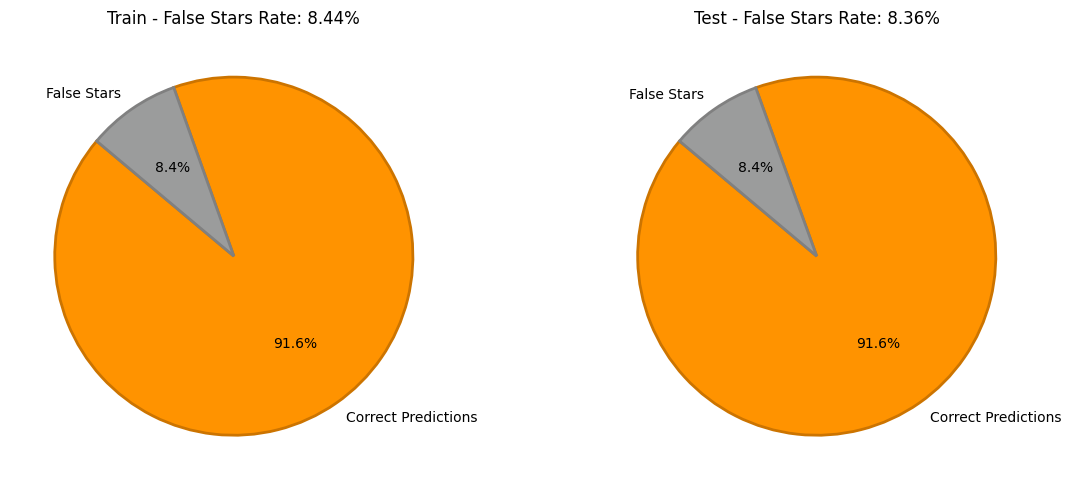

In [44]:
import matplotlib.pyplot as plt

#Train
false_stars_train_pca = conf_matrix_values_train_pca[1][0]
true_galaxies_train_pca = conf_matrix_values_train_pca[1][1]

false_stars_train_rate_pca = ((false_stars_train_pca) / (false_stars_train_pca + true_galaxies_train_pca)) * 100
false_stars_train_rate_pca = round(false_stars_train_rate_pca, 2)

#Test
false_stars_test_pca = conf_matrix_values_test_pca[1][0]
true_galaxies_test_pca = conf_matrix_values_test_pca[1][1]

false_stars_test_rate_pca = ((false_stars_test_pca) / (false_stars_test_pca + true_galaxies_test_pca)) * 100
false_stars_test_rate_pca = round(false_stars_test_rate_pca, 2)


##PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors_train = ["#ff9300", "#9b9c9c"]
edge_colors = ["#cc7400", "#808080"]

#Train
sizes_train = [100 - false_stars_train_rate_pca, false_stars_train_rate_pca]
wedges_train, _, autotexts_train = axes[0].pie(
    sizes_train, labels=["Correct Predictions", "False Stars"], autopct='%1.1f%%', colors=colors_train, startangle=140,
    wedgeprops={"linewidth": 2}  # General border thickness
)

for wedge, edge_color in zip(wedges_train, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[0].set_title(f"Train - False Stars Rate: {false_stars_train_rate_pca}%")


#Test
sizes_test = [100 - false_stars_test_rate_pca, false_stars_test_rate_pca]
wedges_test, _, autotexts_test = axes[1].pie(
    sizes_test, labels=["Correct Predictions", "False Stars"], autopct='%1.1f%%', colors=colors_train, startangle=140,
    wedgeprops={"linewidth": 2}  # General border thickness
)

for wedge, edge_color in zip(wedges_test, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[1].set_title(f"Test - False Stars Rate: {false_stars_test_rate_pca}%")


plt.tight_layout()
plt.show()

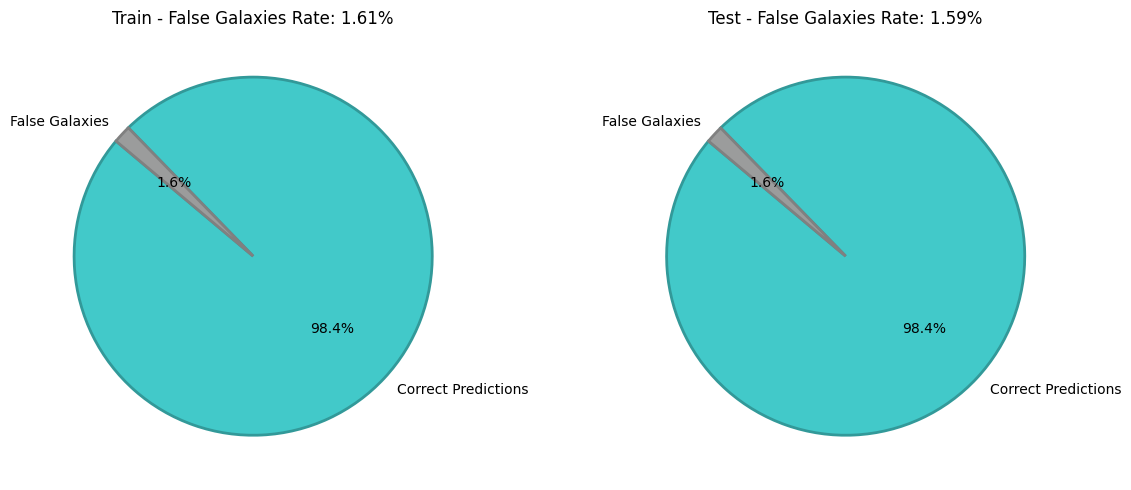

In [45]:
import matplotlib.pyplot as plt

#Train
false_galaxies_train_pca = conf_matrix_values_train_pca[0][1]
true_stars_train_pca = conf_matrix_values_train_pca[0][0]

false_galaxies_train_rate_pca = ((false_galaxies_train_pca) / (false_galaxies_train_pca + true_stars_train_pca)) * 100
false_galaxies_train_rate_pca = round(false_galaxies_train_rate_pca, 2)

#Test
false_galaxies_test_pca = conf_matrix_values_test_pca[0][1]
true_stars_test_pca = conf_matrix_values_test_pca[0][0]

false_galaxies_test_rate_pca = ((false_galaxies_test_pca) / (false_galaxies_test_pca + true_stars_test_pca)) * 100
false_galaxies_test_rate_pca = round(false_galaxies_test_rate_pca, 2)


##PLOTS
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

colors = ["#42c9c9", "#9b9c9c"] 
edge_colors = ["#329999", "#808080"] 

#Train
sizes_train = [100 - false_galaxies_train_rate_pca, false_galaxies_train_rate_pca]
wedges_train, _, autotexts_train = axes[0].pie(
    sizes_train, labels=["Correct Predictions", "False Galaxies"], autopct='%1.1f%%', colors=colors, startangle=140,
    wedgeprops={"linewidth": 2}  # General border thickness
)

for wedge, edge_color in zip(wedges_train, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[0].set_title(f"Train - False Galaxies Rate: {false_galaxies_train_rate_pca}%")


#Test
sizes_test = [100 - false_galaxies_test_rate_pca, false_galaxies_test_rate_pca]
wedges_test, _, autotexts_test = axes[1].pie(
    sizes_test, labels=["Correct Predictions", "False Galaxies"], autopct='%1.1f%%', colors=colors, startangle=140,
    wedgeprops={"linewidth": 2}
)

for wedge, edge_color in zip(wedges_test, edge_colors):
    wedge.set_edgecolor(edge_color)

axes[1].set_title(f"Test - False Galaxies Rate: {false_galaxies_test_rate_pca}%")


plt.tight_layout()
plt.show()

As before, the errors are similar in training and testing, which means that the model is not overfitted.

# Images

As we need also de images, when making the query in https://skyserver.sdss.org/dr18, we especified:
- the location of the object (with right ascension (RA) and declination (dec))
- the zoom of the picture (scale)
- the dimmensions of the photo (with and height)

These images will be saved into a "images" folder splitted into train and test and each one splitted as galaxies or stars. In a visual way would be:

![](notebookImages/folderSchema.png)

   


In [ ]:
!python download_images.py

## Data preprocessing

First it is necessary to know the amount of channels we are going to work with. For that, we are going to take one photo and verify it.

In [47]:
import cv2
import os
import config

image_path = config.IMAGES_PATH + "/train/star"

#Get all the images
images = [f for f in os.listdir(image_path) if f.endswith((".jpg"))]

image_path = os.path.join(image_path, images[0]) #Get the first photo

image = cv2.imread(image_path) #Read the first photo

if len(image.shape) == 2:
    print("Image with grayscale.")
elif len(image.shape) == 3 and image.shape[2] == 3:
    print("Image with 3 channels (RGB).")
elif len(image.shape) == 3 and image.shape[2] == 4:
    print("Image with 4 channels (RGBA).") #RGB + Alpha (opacity of the image)

Image with 3 channels (RGB).


As we can see our images have 3 channels RGB. Now, we are going to normalize the pixels values  because we are going to work with a neural network and usually this improves the model performance and facilitate the process of learning. For that we need to calculate the mean and std for our images, and then apply those values to normalize. 

In [48]:
import torch
import numpy as np
from torchvision import datasets, transforms

def calculate_mean_std(dataloader):
    mean = 0.0
    std = 0.0
    total_images = 0

    for img, _ in dataloader:
        batch_samples = img.size(0)  #Amount of images per batch
        img = img.view(batch_samples, img.size(1), -1)  #Reorganize the tensor of images. If img has the shape
        #of (batch, channels, height, width), it will be flatted; which means that all pixels of a channel will
        #be put in a single dimension so we can obtain the mean and the std.
        mean += img.mean(2).mean(0)  #Mean by channel
        std += img.std(2).std(0)  #std per channel

        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

We are going to transform the images: Convert them into tensors and apply normalization. After that, we are going to get the train, test and validation datasets and also, use them to create the DataLoaders. The used batch size was to start with something, but then we will try to optimize the hyperparameters using a grid.

In [49]:
from torch.utils.data import DataLoader

#Dataset and loader for all the images
full_dataset = datasets.ImageFolder(config.IMAGES_PATH, transform=transforms.ToTensor())
full_loader = DataLoader(full_dataset, batch_size=32, shuffle=False)

#Calculate the mean and std to normalize the images
mean, std = calculate_mean_std(full_loader)

#Transform the images (convert them into tensors + normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=mean.tolist(), std=std.tolist())
])

#Get the train, test and validation datasets
train_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/train", transform=transform)
test_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/test", transform=transform)
validation_dataset = datasets.ImageFolder(root=config.IMAGES_PATH+"/validation", transform=transform)

#Create the DataLoader for train, test and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation_dataset, batch_size=32, shuffle=False)

## Analysis

First, we will verify if the images are correctly imported and transformed (convert them into tensors and normalize them).

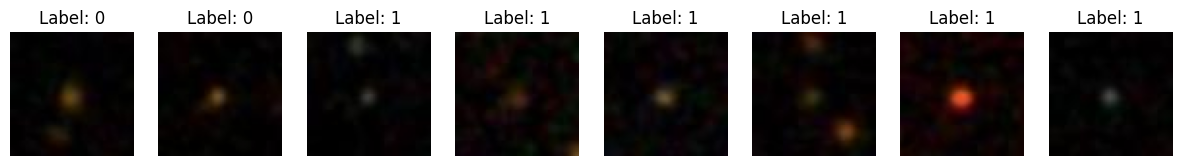

In [50]:
import matplotlib.pyplot as plt
import numpy as np


def show_images(data_loader, mean, std, num_images):
    data_iter = iter(data_loader) #Convert dataLoader into an iterable
    images, labels = next(data_iter) #Get the next batch (a set of images processed simultaneously)

    #Plot to show images
    fig, axes = plt.subplots(1, num_images, figsize=(15, 15))
    
    #Ensure that the mean and std is arrays of numpy
    mean = np.array(mean.tolist())
    std = np.array(std.tolist())
    
    #For each image
    for i in range(num_images):
        image = images[i].permute(1, 2, 0).numpy()  #Change the format of images, matplolib needs (H, W, C)
        
        #Undo the normalization to see correctly the images
        image = image * std + mean
        
        image = np.clip(image, 0, 1) #Ensure that images pixels are between 0 and 1 values (to see correctly the image)
        #If a value is less than 0, that pixel would be fully black or with errors.
        #If a value is bigger than 1 the colors could be saturated.
        
        #Plot the image
        ax = axes[i]
        ax.imshow(image)
        ax.set_title(f"Label: {labels[i].item()}")
        ax.axis('off')

    plt.show()

show_images(train_loader, mean, std, num_images=8)


Now, we are going to see the amount of data we have for train, test and validation.

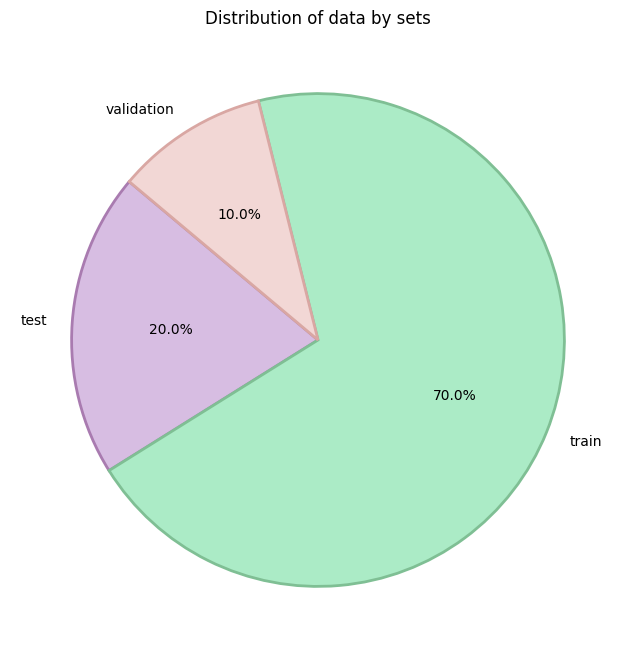

In [51]:
import matplotlib.pyplot as plt
import pandas as pd

class_names = full_dataset.classes  #Class names list
class_counts = {class_name: 0 for class_name in class_names}  #Create the dictionary to count the amount of images for each class

#Count images by class
for _, label in full_dataset.samples:  #List (image_path, label)
    class_name = class_names[label]
    class_counts[class_name] += 1

#Convert it into a dataFrame
data = pd.DataFrame({
    "Type": list(class_counts.keys()),
    "Count": list(class_counts.values())
})

#Calculate the percentage
total_count = data["Count"].sum()
data["Percentage"] = (data["Count"] / total_count) * 100

colors = ["#d7bde2", "#abebc6", "#f2d7d5"] 
edge_colors = ["#a97bb0", "#7fbf94", "#D9A7A3"]

##PLOT
plt.figure(figsize=(8, 8))
wedges, _, autotexts = plt.pie(
    data["Count"],
    labels=data["Type"],
    autopct="%1.1f%%",
    colors=colors,
    startangle=140,
    wedgeprops={"linewidth": 2}
)

#Set the borders colors
for wedge, edge_color in zip(wedges, edge_colors):
    wedge.set_edgecolor(edge_color)

plt.title("Distribution of data by sets")
plt.show()

Now, as we did for the CSV, we will count the amount of stars and galaxies we have. As the data is splitted into train, test and validation, we have to count them separately and the join them.

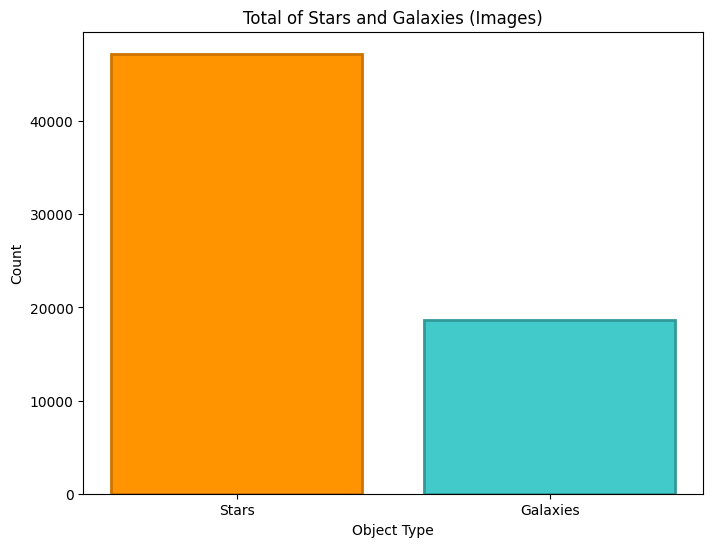

In [ ]:
import matplotlib.pyplot as plt

class_names = train_dataset.classes  #List with class names
class_counts = {class_name: 0 for class_name in class_names}  #Create the dictionary to count the amount of images for each class

#Function to count images and generate the DataFrame
def get_class_counts(dataset):
    class_names = dataset.classes  #List with class names (galaxy, star)
    class_counts = {class_name: 0 for class_name in class_names}  #Create dictionary to count images per class

    #Count images by class
    for _, label in dataset.samples:  #List (image_path, label)
        class_name = class_names[label]
        class_counts[class_name] += 1

    #Convert to DataFrame and calculate percentage
    data = pd.DataFrame({
        "Type": list(class_counts.keys()),
        "Count": list(class_counts.values())
    })

    return data

#Get the DataFrames for each dataset
train_data = get_class_counts(train_dataset)
val_data = get_class_counts(validation_dataset)
test_data = get_class_counts(test_dataset)


#Merge the data from the three datasets into a single DataFrame
combined_data = pd.merge(train_data, val_data, on="Type", suffixes=('_Train', '_Validation'))
combined_data = pd.merge(combined_data, test_data.rename(columns={"Count": "Count_Test"}), on="Type")

#Calculating the totals
stars_total = combined_data[combined_data["Type"] == "star"]['Count_Train'].sum() + combined_data[combined_data["Type"] == "star"]['Count_Validation'].sum() + combined_data[combined_data["Type"] == "star"]['Count_Test'].sum()
galaxies_total = combined_data[combined_data["Type"] == "galaxy"]['Count_Train'].sum() + combined_data[combined_data["Type"] == "galaxy"]['Count_Validation'].sum() + combined_data[combined_data["Type"] == "galaxy"]['Count_Test'].sum()

#Create a new DataFrame to plot it
total_data = pd.DataFrame({
    "Type": ["Stars", "Galaxies"],
    "Total Count": [stars_total, galaxies_total]
})

#PLOTS
plt.figure(figsize=(8, 6))
plt.bar(total_data["Type"], total_data["Total Count"], color=["#ff9300", "#42c9c9"], edgecolor=["#cc7400", "#329999"], linewidth=2)
plt.xlabel("Object Type")
plt.ylabel("Count")
plt.title("Total of Stars and Galaxies (Images)")

plt.show()


To know if the distribution of images is the same for all the sets, we are going to use a pie chart and the percentages of each class.

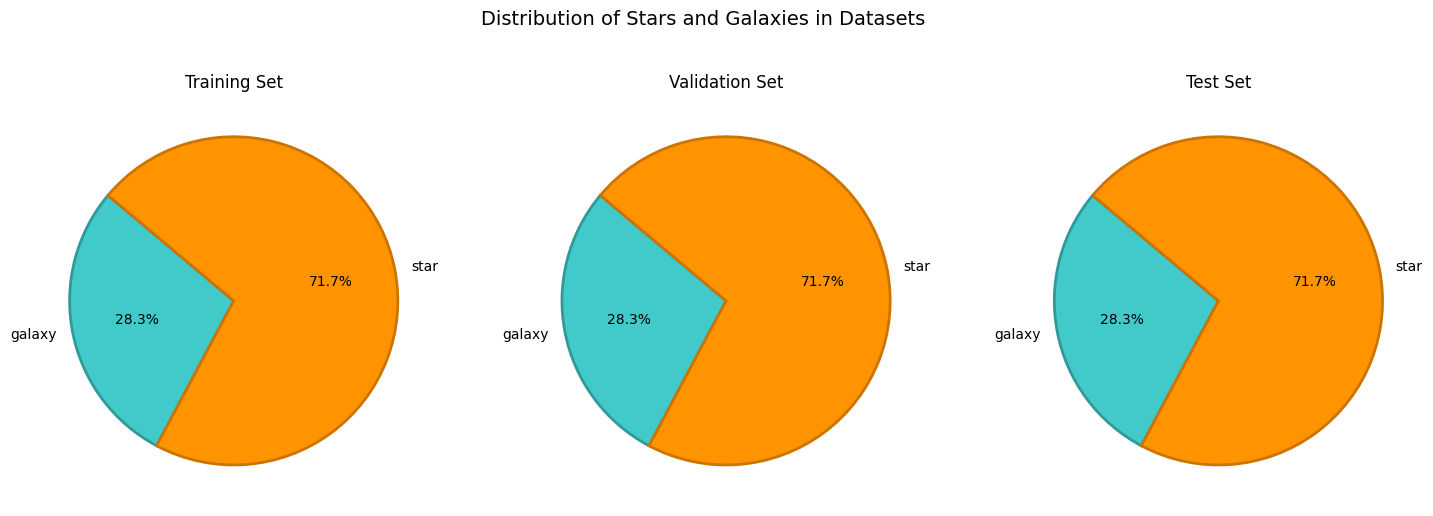

In [53]:
import matplotlib.pyplot as plt
import pandas as pd


#Function to count images and generate the DataFrame
def add_percentage(data):
    data["Percentage"] = (data["Count"] / data["Count"].sum()) * 100
    return data

train_data = add_percentage(train_data)
val_data = add_percentage(val_data)
test_data = add_percentage(test_data)

#Datasets and titles
datasets = [(train_data, "Training Set"), (val_data, "Validation Set"), (test_data, "Test Set")]


##PLOT
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

colors = ["#42c9c9", "#ff9300"]
edge_colors = ["#329999", "#cc7400"]


#Plot each dataset in a subplot
for ax, (data, title) in zip(axes, datasets):
    wedges, texts, autotexts = ax.pie(
        data["Count"],
        labels=data["Type"],
        autopct="%1.1f%%",
        colors=colors,
        startangle=140,
        wedgeprops={"linewidth": 2}
    )

    #Set the color for the border
    for wedge, edge_color in zip(wedges, edge_colors):
        wedge.set_edgecolor(edge_color)

    ax.set_title(title)

plt.suptitle("Distribution of Stars and Galaxies in Datasets", fontsize=14)
plt.show()


### Model

Now, we are going to try 2 different models.
1. **Simple CNN**:
   - **3 convolutional layers**: They get images with 3 channels and each one extract different amount of characteristics depending on the quantity of neurons. Moreover, they use a padding of 1.
      - First one: Extracts 64 characteristics with 3x3 filters. Them applies ReLU and max pooling to reduce a half the resolution.
      - Second one: Increases to 128 filters and ReLU and max pooling again.
      - Third one: Increases to 256 filters and ReLU and max pooling again.
   - **1 fully connected layer**: After the image has been reduced and flatted (multiplying 256·8·8), the neural network will predict the class.

2. **CNN + SE Blocks**:
   - **3 convolutional layers**: They get images with 3 channels (RGB) and each one extract different amount of characteristics depending on the quantity of neurons. Moreover, they use a padding of 1. Same than before.
   - **3 SE Blocks**: These blocks will help the model to learn which channels are the ones that give more useful information, so this block will help the network to prioritize these channels automaticaly. They have 3 key steps: Squeeze → Excitation → Recalibration.
      - **Squeeze (Dimensionality reduction)**: It will have as an input the tensor with shape (batch_size, channels, height, width). For each channel will compute the average and the result will be another tensor of size (batch_size, channels, 1, 1) that will be flatted into (batch_size, channels) shape. This will **summarize the spatial information** (height and width) of each channel into a one single number.
      - **Excitation (Learning importance of channels)**: It will go through a small network with two lineal layers:
         - First layer (fc1): Reduces the dimension. In this case, if we have 256 channels, will be reduced into 16.
         - Second layer (fc2): The opposite action. In this case, will change from 16 to 256.
         
         The output of this will be weights between 0 and 1 of size (batch_size, channels). These values are the "importance level" of each channel.
      - **Recalibration (channels recalibration)**: Each channel of the original tensor will be multiplied by its weight.
      With this what we get is that the more important channels have biggest values so they will contribute more to the output.

*Remember*: When we talk about channels we have to difference between RGB channels (just applied as input at first) and CNN channels, which are the outputs we get after applying the convolutional filters. In this case will be 64, 128 and 256. Each CNN channel represents a different detected characteristic.


#### Preparation

Now, we are going to train, evaluate and compare the models to know which one performs better. For both we will use same optimizer with the same learning rate, criterion and number of epochs.

In [ ]:
import cnn
from torch.utils.tensorboard import SummaryWriter
import torch

#In case the gpu is accessible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Create the model and use the selected
model_cnn = cnn.CNN(num_classes=2)
model_cnn.to(device)

#Define the optimizer and the loss function
optimizer = torch.optim.Adam(model_cnn.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss() #Implicity softmax

#Use tensorflow to see the loss functions plots and metrics
writer = SummaryWriter()

epochs = 100
cnn.train_model(train_loader, test_loader, model_cnn, optimizer, criterion, epochs, device, writer, checkpoint_path = "checkpoints/checkpointCNN.pth")

writer.close()

Checkpoint loaded from checkpoints/checkpointCNN.pth. Starting from the epoch 100
Epoch [100/100], Train Loss: 0.0031, Test Loss: 0.0895
Checkpoint saved in checkpoints/checkpointCNN.pth


AUC-ROC: 0.9091


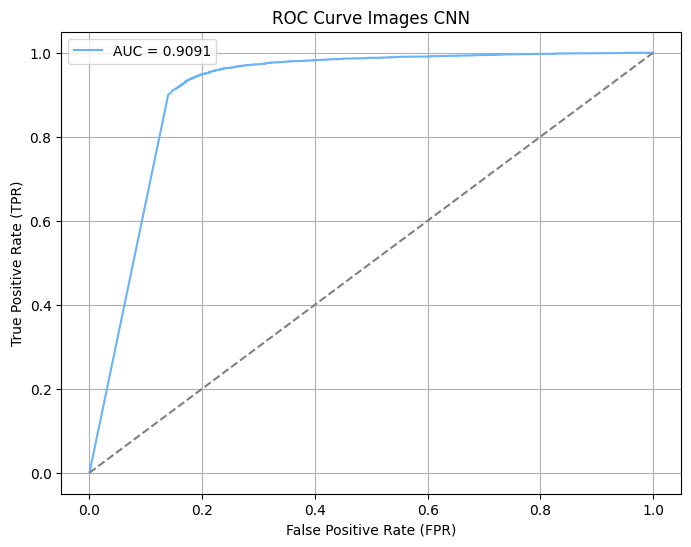

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

#Test evaluation
model_cnn.eval()
all_probs_cnn = []
all_labels_cnn = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        #Get the probabilities of the positive class (galaxy)
        outputs = model_cnn(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  #Probability for class 1 (galaxy)

        all_probs_cnn.extend(probs.cpu().numpy())  #Convert it into numpy
        all_labels_cnn.extend(labels.cpu().numpy())  #Keep the real labels

#Calculate the AUC-ROC
auc_score = roc_auc_score(all_labels_cnn, all_probs_cnn)
print(f"AUC-ROC: {auc_score:.4f}")

#Get FRP and TRP for ROC curve
fpr_cnn, tpr_cnn, _ = roc_curve(all_labels_cnn, all_probs_cnn)

#PLOT
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn, tpr_cnn, label=f'AUC = {auc_score:.4f}', color='#69b3fb')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Images CNN')
plt.legend()
plt.grid()
plt.show()

In [56]:
import torch
from torch.utils.tensorboard import SummaryWriter
import cnn_se

#Create the model and use the selected
model_cnn_se = cnn_se.CNNWithSE(num_classes=2)
model_cnn_se.to(device)

#Define the optimizer and the loss function
optimizer = torch.optim.Adam(model_cnn_se.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

#Use tensorflow to see the loss functions plots and metrics
writer = SummaryWriter()


epochs = 100
cnn_se.train_model(train_loader, test_loader, model_cnn_se, optimizer, criterion, epochs, device, writer, checkpoint_path = "checkpoints/checkpointCNN_SE.pth")


writer.close()


Checkpoint loaded from checkpoints/checkpointCNN_SE.pth. Starting from the epoch 100
Epoch [100/100], Train Loss: 0.0004, Test Loss: 0.0372
Checkpoint saved in checkpoints/checkpointCNN_SE.pth


AUC-ROC: 0.9403


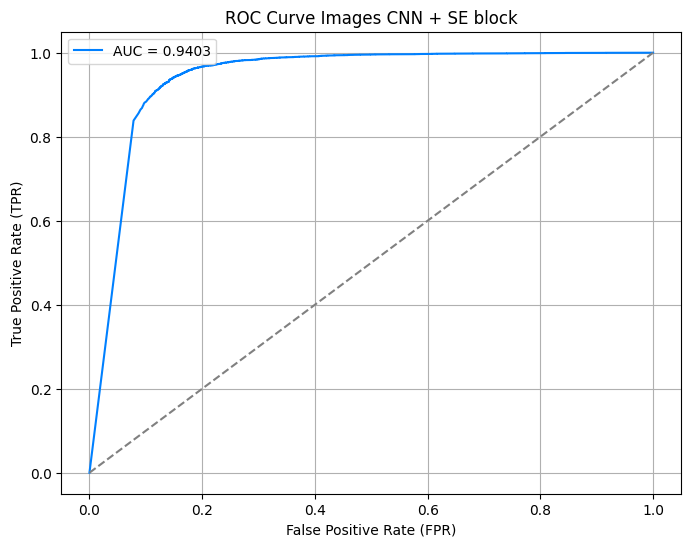

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

#Evaluation in the test set
model_cnn_se.eval()
all_probs_cnn_se = []
all_labels_cnn_se = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        #Get the probabilities for the positive class (galaxy)
        outputs = model_cnn_se(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  #Probability for the class 1 (galaxy)

        all_probs_cnn_se.extend(probs.cpu().numpy())  #Transform it to numpy
        all_labels_cnn_se.extend(labels.cpu().numpy())  #Save the true labels

#Calculate AUC-ROC curve with the obtained probabilities and labels
auc_score = roc_auc_score(all_labels_cnn_se, all_probs_cnn_se)
print(f"AUC-ROC: {auc_score:.4f}")

#Obtain FPR y TPR for the ROC curve
fpr_cnn_se, tpr_cnn_se, _ = roc_curve(all_labels_cnn_se, all_probs_cnn_se)

#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_cnn_se, tpr_cnn_se, label=f'AUC = {auc_score:.4f}', color='#0080ff')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  #Diagonal line for "random" classification
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Images CNN + SE block')
plt.legend()
plt.grid()
plt.show()

After comparing both, we can see that the SE blocks improve slightly the performance. The blue one is the simple CNN while the pink CNN + SE blocks.

![](notebookImages/original.png)


If we smooth the result we can see that the learning curve has the expected shape.

![](notebookImages/smoothed.png)


Now, we are going to try to improve the results by using a grid and trying differents hyperparameters to get the best ones. For that I used the next code (it needs a lot of time). **READ THE NEXT MARKDOWN BEFORE EXECUTING IT** 

In [58]:
from optimize_hyperparameters import optimize_hyperparameters

best_params = optimize_hyperparameters(train_dataset, validation_dataset, device, checkpoint_path = "checkpoints/checkpoint_hyper_optimization")
print("Best hyperparameters found:", best_params)

Training with hyperparameters: {'batch_size': 32, 'epochs': 10, 'lr': 0.01}
Saving checkpoint at: checkpoints/checkpoint_hyper_optimization_lr_0.01_batch_32_epochs_10.pth
Checkpoint loaded from checkpoints/checkpoint_hyper_optimization_lr_0.01_batch_32_epochs_10.pth. Starting from the epoch 10
Epoch [10/10], Train Loss: 0.0186, Test Loss: 0.0186
Checkpoint saved in checkpoints/checkpoint_hyper_optimization_lr_0.01_batch_32_epochs_10.pth
Validation loss: 0.0186
Training with hyperparameters: {'batch_size': 32, 'epochs': 10, 'lr': 0.001}
Saving checkpoint at: checkpoints/checkpoint_hyper_optimization_lr_0.001_batch_32_epochs_10.pth
Checkpoint loaded from checkpoints/checkpoint_hyper_optimization_lr_0.001_batch_32_epochs_10.pth. Starting from the epoch 10
Epoch [10/10], Train Loss: 0.0041, Test Loss: 0.0116
Checkpoint saved in checkpoints/checkpoint_hyper_optimization_lr_0.001_batch_32_epochs_10.pth
Validation loss: 0.0116
Training with hyperparameters: {'batch_size': 32, 'epochs': 10, 'l

If you run the previous cell, you will obtain the best hyperparameters. If you have already executed it, you can safely run the next cell, as it will assign the corresponding optimal values to the variables. However, if you do not have time to run it (in my case, it took three and a half hours without the checkpoints and 10 minutes with the chekpoints), you can run the next cell instead, where I assign the values I obtained.

As shown in the following picture, these were the values I got after running the first cell. Since I reset the kernel, I cannot assign them directly, so I need to do it manually. Nevertheless, I am including an image to show that these were  the obtained results after running the code.

![](notebookImages/hyper_opt.png)


In [59]:
batch_size_opt = best_params["batch_size"]
epochs_opt = best_params["epochs"]
lr_opt = best_params["lr"]

print(f"Best batch size: {batch_size_opt}")
print(f"Best number of epochs: {epochs_opt}")
print(f"Best learning rate: {lr_opt}")


Best batch size: 128
Best number of epochs: 20
Best learning rate: 0.01


If you get a different solution this could be because the function has different minimums, so you reached to another one.

In [60]:
batch_size_opt = 128
epochs_opt = 10
lr_opt = 0.0001

After getting the optimized hyperparameters, we will use them to get a better performance.

In [61]:
import torch
from torch.utils.tensorboard import SummaryWriter
import cnn_se

train_loader_opt = DataLoader(train_dataset, batch_size=batch_size_opt, shuffle=True)
test_loader_opt = DataLoader(test_dataset, batch_size=batch_size_opt, shuffle=False)

#Create the model and use the selected
model_cnn_se_opt = cnn_se.CNNWithSE(num_classes=2)
model_cnn_se_opt.to(device)

#Define the optimizer and the loss function
optimizer = torch.optim.Adam(model_cnn_se_opt.parameters(), lr=lr_opt)
criterion = torch.nn.CrossEntropyLoss()

#Use tensorflow to see the loss functions plots and metrics
writer = SummaryWriter()


cnn_se.train_model(train_loader_opt, test_loader_opt, model_cnn_se_opt, optimizer, criterion, epochs_opt, device, writer, checkpoint_path = "checkpoints/checkpointCNN_SE_optimized.pth")


writer.close()

Checkpoint loaded from checkpoints/checkpointCNN_SE_optimized.pth. Starting from the epoch 10
Epoch [10/10], Train Loss: 0.0008, Test Loss: 0.0017
Checkpoint saved in checkpoints/checkpointCNN_SE_optimized.pth


AUC-ROC: 0.9776


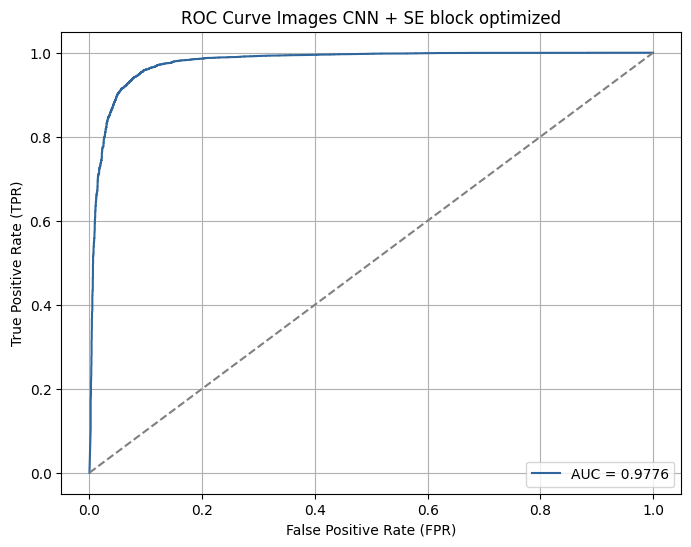

In [ ]:
#Evaluation in the test set
model_cnn_se_opt.eval()
all_probs_opt = [] 
all_labels_opt = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        #Get the probabilities for the positive class (galaxy)
        outputs = model_cnn_se_opt(images)
        probs = torch.softmax(outputs, dim=1)[:, 1]  #Probability for the class 1 (galaxy)

        all_probs_opt.extend(probs.cpu().numpy())  #Transform it to numpy
        all_labels_opt.extend(labels.cpu().numpy())  #Save the true labels

#Calculate AUC-ROC curve with the obtained probabilities and labels
auc_score = roc_auc_score(all_labels_opt, all_probs_opt)
print(f"AUC-ROC: {auc_score:.4f}")

#Obtain FPR y TPR for the ROC curve
fpr_opt, tpr_opt, _ = roc_curve(all_labels_opt, all_probs_opt)

#Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_opt, tpr_opt, label=f'AUC = {auc_score:.4f}', color='#2f669c')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea diagonal
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve Images CNN + SE block optimized')
plt.legend()
plt.grid()
plt.show()


### Comparison between all models

We are going the three ROC curves to compare them more easily.

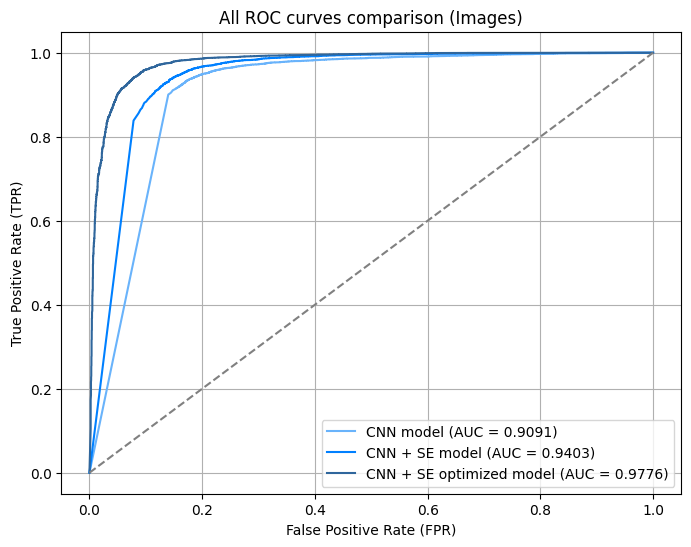

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score

#Dictionary to keep FRP, TRP and AUC of each model
roc_data = {}

#Enter the calculated values in the last ROC curves 
model_names = ["CNN model", "CNN + SE model", "CNN + SE optimized model"]
all_probs_list = [all_probs_cnn, all_probs_cnn_se, all_probs_opt] 
all_labels_list = [all_labels_cnn, all_labels_cnn_se, all_labels_opt]
colors = ["#69b3fb", "#0080ff", "#2f669c"]

plt.figure(figsize=(8, 6))

for i, (probs, labels, name, color) in enumerate(zip(all_probs_list, all_labels_list, model_names, colors)):
    #Calculate FPR, TPR and AUC
    fpr, tpr, _ = roc_curve(labels, probs)
    auc_score = roc_auc_score(labels, probs)

    #Keep it in the dictionary
    roc_data[name] = {'fpr': fpr, 'tpr': tpr, 'auc': auc_score}

    #Plot it
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc_score:.4f})', color=color)


plt.plot([0, 1], [0, 1], linestyle='--', color='gray') #Diagonal line for "random" classification
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('All ROC curves comparison (Images)')
plt.legend()
plt.grid()
plt.show()


# Conclusions

AUC:
- Logistic regression (without PCA): 0.9920
    - Regularization: 0.9066
- Logistic regression (with PCA): 0.9918
    - Regularization: 
- CNN + SE blocks: 0.9776

As we can see, all the models perform very well when classifying objects into stars and galaxies. The differences are very small. Moreover, if we have to compare the logistic regression with PCA and without PCA, we get almost the same values. Remember that we removed 15 characteristics, which is amazing taking into account that the difference between them is a 0.02%. This help us to get a simpler model without losing accuracy.

We can also observe that regularization slightly penalizes the AUC value. However, this technique helps improve the model’s generalization ability by preventing overfitting, which is crucial for achieving better performance on unseen data.

On the other hand, while the CNN with SE blocks shows a slightly lower AUC score, it still performs well. This highlights that a more complex model doesn’t always guarantee better results—logistic regression, being much simpler, performs better in this case.



